Number of images in Normal class: 1589
Number of images in Osteoarthritis class: 2257


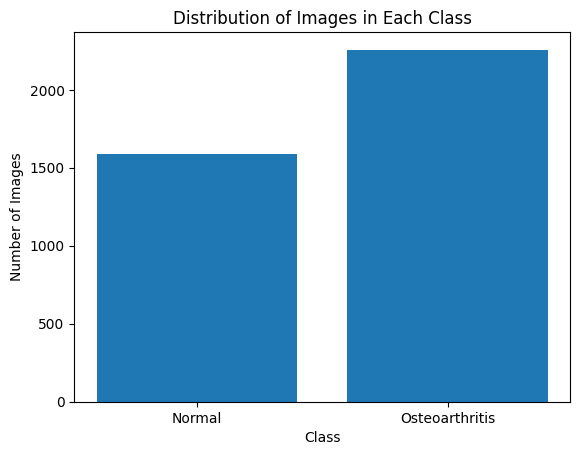

In [1]:
import os
import cv2
import matplotlib.pyplot as plt

def load_and_resize_images_from_folder(folder, target_size=(224, 224)):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            img = cv2.resize(img, target_size)
            images.append(img)
    return images

# Load images from directories for each class
normal_images = load_and_resize_images_from_folder('/home/lab4/ML2/OsteoArthritis-20240311T154242Z-001/OsteoArthritis/Normal')
osteoarthritis_images = load_and_resize_images_from_folder('/home/lab4/ML2/OsteoArthritis-20240311T154242Z-001/OsteoArthritis/Osteoarthritis')

# Display the number of images in each class
print("Number of images in Normal class:", len(normal_images))
print("Number of images in Osteoarthritis class:", len(osteoarthritis_images))

# Create a histogram to visualize the distribution of images in each class
plt.bar(['Normal', 'Osteoarthritis'], [len(normal_images), len(osteoarthritis_images)])
plt.title('Distribution of Images in Each Class')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.show()


2024-03-23 17:44:15.510196: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-23 17:44:15.511010: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-23 17:44:15.548959: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-23 17:44:15.738687: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-23 17:44:16.214192: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warnin

Number of images in Normal class: 1589
Number of images in Osteoarthritis class: 2257
Number of images in Normal class after augmentation: 2257


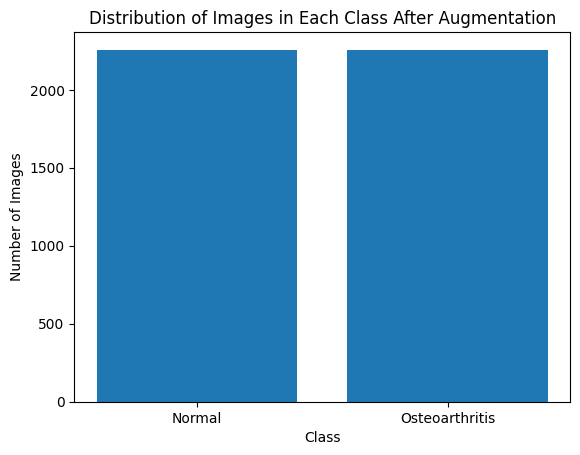

In [2]:
import os
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# Define a function to load and resize images from a folder
def load_and_resize_images_from_folder(folder, target_size=(224, 224)):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            img = cv2.resize(img, target_size)
            images.append(img)
    return images

# Load images from directories for each class
normal_images = load_and_resize_images_from_folder('/home/lab4/ML2/OsteoArthritis-20240311T154242Z-001/OsteoArthritis/Normal')
osteoarthritis_images = load_and_resize_images_from_folder('/home/lab4/ML2/OsteoArthritis-20240311T154242Z-001/OsteoArthritis/Osteoarthritis')

# Display the number of images in each class
print("Number of images in Normal class:", len(normal_images))
print("Number of images in Osteoarthritis class:", len(osteoarthritis_images))

# Check if data augmentation is needed
if len(normal_images) < len(osteoarthritis_images):
    # Calculate the number of additional images needed
    num_additional_images = len(osteoarthritis_images) - len(normal_images)

    # Create an ImageDataGenerator for data augmentation
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    # Choose random indices from the "Normal" class for augmentation
    sampled_indices = np.random.randint(0, len(normal_images), size=num_additional_images)

    # Perform data augmentation and append augmented images to the "Normal" class
    for index in sampled_indices:
        img = normal_images[index]
        img = img.reshape((1,) + img.shape)  # Reshape for flow() function
        for batch in datagen.flow(img, batch_size=1):
            normal_images.append(batch[0])  # Append augmented images
            break  # Exit the loop after one iteration of data augmentation

    # Display the number of images in the "Normal" class after augmentation
    print("Number of images in Normal class after augmentation:", len(normal_images))

# Create a histogram to visualize the distribution of images in each class after augmentation
plt.bar(['Normal', 'Osteoarthritis'], [len(normal_images), len(osteoarthritis_images)])
plt.title('Distribution of Images in Each Class After Augmentation')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.show()


In [3]:
import random

# Set a seed for reproducibility
random.seed(42)

# Randomly select 1000 images from each class
selected_normal_images = random.sample(normal_images, 2000)
selected_osteoarthritis_images = random.sample(osteoarthritis_images, 2000)

# Combine selected images from both classes
selected_images = selected_normal_images + selected_osteoarthritis_images
labels = [0] * 2000 + [1] * 2000  # Assign labels (0 for Normal, 1 for Osteoarthritis)

# Split the selected images and labels into train and test sets (70:30 ratio)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(selected_images, labels, test_size=0.3, random_state=42)

# Split the train set into train and validation sets (80:20 ratio)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Print the sizes of train, test, and validation sets
print("X_train size:", len(X_train))
print("X_test size:", len(X_test))
print("X_validation size:", len(X_val))


X_train size: 2240
X_test size: 1200
X_validation size: 560


In [4]:
import pandas as pd
from sklearn.metrics import balanced_accuracy_score,cohen_kappa_score,matthews_corrcoef

# ResNet

In [5]:
import tensorflow as tf
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array

# Preprocess the loaded images
X_train_preprocessed = np.array([img_to_array(image) for image in X_train])
X_val_preprocessed = np.array([img_to_array(image) for image in X_val])
X_test_preprocessed = np.array([img_to_array(image) for image in X_test])

# Preprocess the image data
X_train_preprocessed = tf.keras.applications.resnet50.preprocess_input(X_train_preprocessed)
X_val_preprocessed = tf.keras.applications.resnet50.preprocess_input(X_val_preprocessed)
X_test_preprocessed = tf.keras.applications.resnet50.preprocess_input(X_test_preprocessed)



# Encode the labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

# Load ResNet-50 model with pre-trained ImageNet weights
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,112,513 (91.98 MB)

 Trainable params: 524,801 (2.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [5]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train_preprocessed, y_train_encoded, batch_size=32, epochs=50, 
                    validation_data=(X_val_preprocessed, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 48s 655ms/step - accuracy: 0.6701 - loss: 0.8176 - val_accuracy: 0.7750 - val_loss: 0.4529
Epoch 2/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 47s 680ms/step - accuracy: 0.8249 - loss: 0.3708 - val_accuracy: 0.8536 - val_loss: 0.3269
Epoch 3/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 48s 680ms/step - accuracy: 0.8622 - loss: 0.3162 - val_accuracy: 0.8464 - val_loss: 0.3331
Epoch 4/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 47s 679ms/step - accuracy: 0.8641 - loss: 0.3007 - val_accuracy: 0.8429 - val_loss: 0.3390
Epoch 5/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 48s 681ms/step - accuracy: 0.8928 - loss: 0.2574 - val_accuracy: 0.8696 - val_loss: 0.2900
Epoch 6/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 47s 680ms/step - accuracy: 0.9044 - loss: 0.2374 - val_accuracy: 0.8732 - val_loss: 0.2953
Epoch 7/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 48s 681ms/step - accuracy: 0.8996 - loss: 0.2333 - val_accuracy: 0.7911 - val_loss: 0.4433
Epoch 8/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 48s 680ms/step - accuracy: 0.9096 - loss: 0.2198 - val_accu

38/38 ━━━━━━━━━━━━━━━━━━━━ 22s 552ms/step
Inference Time: 21.88709020614624 seconds
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 524ms/step - accuracy: 0.8814 - loss: 0.2765
Validation Loss: 0.2731485068798065
Validation Accuracy: 0.8839285969734192
38/38 ━━━━━━━━━━━━━━━━━━━━ 20s 535ms/step - accuracy: 0.8762 - loss: 0.2837
Test Loss: 0.28906261920928955
Test Accuracy: 0.8816666603088379
ROC AUC Score: 0.954442917700464
Confusion Matrix:
[[584  38]
 [104 474]]
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.94      0.89       622
           1       0.93      0.82      0.87       578

    accuracy                           0.88      1200
   macro avg       0.89      0.88      0.88      1200
weighted avg       0.89      0.88      0.88      1200



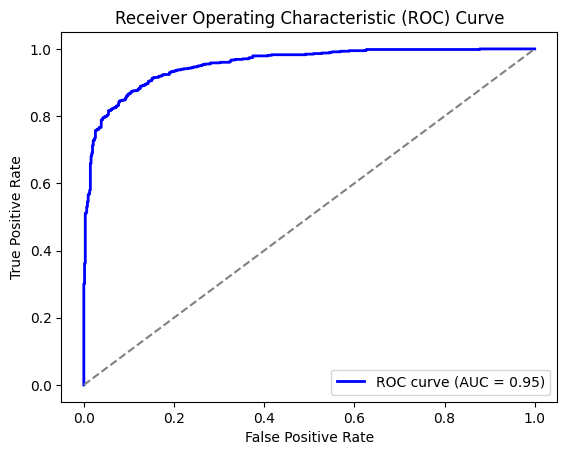

Metrics saved successfully


In [6]:
import time
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score
import pandas as pd
from sklearn.metrics import cohen_kappa_score, matthews_corrcoef, balanced_accuracy_score
# Record start time for inference
start_inference_time = time.time()

# Generate predictions on test data
y_pred_proba = model.predict(X_test_preprocessed)
y_pred_binary = (y_pred_proba > 0.5).astype(int)

# Record end time for inference
end_inference_time = time.time()

# Calculate inference time
inference_time = end_inference_time - start_inference_time
print("Inference Time:", inference_time, "seconds")

# Print validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Calculate test loss and accuracy
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_encoded)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test_encoded, y_pred_proba)
print("ROC AUC Score:", roc_auc)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)
print("Confusion Matrix:")
print(conf_matrix)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)
print("Classification Report:")
print(class_report)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

kappa=cohen_kappa_score(y_test,y_pred_binary)
mcc=matthews_corrcoef(y_test,y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)

metrics={
    'Combination':'Resnet+Dense',
    'Validation Accuracy':val_accuracy*100,
    'Validation Loss':val_loss,
    'Test Accuracy':test_accuracy*100,
    'Test Loss':test_loss,
    'Training time':training_time,
    'Inference time':inference_time,
    'Cohens Kappa':kappa,
    'MCC':mcc,
    'Balanced Accuracy':balanced_accuracy
}
metrics_df=pd.DataFrame(metrics,index=[0])
metrics_df.to_csv('ResNet_4000_epoch_50_metrics.csv',index=False)
print("Metrics saved successfully")

In [7]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train_preprocessed, y_train_encoded, batch_size=32, epochs=100, 
                    validation_data=(X_val_preprocessed, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 48s 685ms/step - accuracy: 0.9289 - loss: 0.1803 - val_accuracy: 0.8929 - val_loss: 0.2837
Epoch 2/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 48s 680ms/step - accuracy: 0.9533 - loss: 0.1335 - val_accuracy: 0.8786 - val_loss: 0.2718
Epoch 3/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 47s 680ms/step - accuracy: 0.9509 - loss: 0.1264 - val_accuracy: 0.8661 - val_loss: 0.3482
Epoch 4/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 48s 681ms/step - accuracy: 0.9442 - loss: 0.1342 - val_accuracy: 0.8929 - val_loss: 0.2756
Epoch 5/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 48s 681ms/step - accuracy: 0.9646 - loss: 0.1045 - val_accuracy: 0.8857 - val_loss: 0.2792
Epoch 6/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 48s 680ms/step - accuracy: 0.9655 - loss: 0.0979 - val_accuracy: 0.8411 - val_loss: 0.4227
Epoch 7/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 48s 680ms/step - accuracy: 0.9625 - loss: 0.1067 - val_accuracy: 0.8714 - val_loss: 0.3342
Training Time: 333.6228446960449 seconds


38/38 ━━━━━━━━━━━━━━━━━━━━ 20s 531ms/step
Inference Time: 20.557086944580078 seconds
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 527ms/step - accuracy: 0.8791 - loss: 0.2682
Validation Loss: 0.27184125781059265
Validation Accuracy: 0.8785714507102966
38/38 ━━━━━━━━━━━━━━━━━━━━ 20s 534ms/step - accuracy: 0.8918 - loss: 0.2677
Test Loss: 0.27431216835975647
Test Accuracy: 0.89083331823349
ROC AUC Score: 0.9565234926957354
Confusion Matrix:
[[566  56]
 [ 75 503]]
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.91      0.90       622
           1       0.90      0.87      0.88       578

    accuracy                           0.89      1200
   macro avg       0.89      0.89      0.89      1200
weighted avg       0.89      0.89      0.89      1200



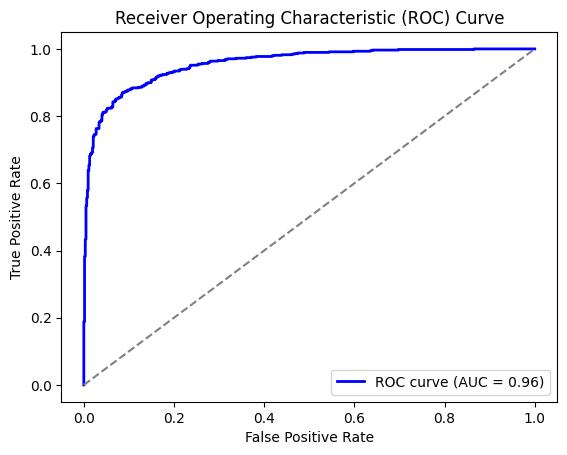

Metrics saved successfully


In [8]:
import time
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score

# Record start time for inference
start_inference_time = time.time()

# Generate predictions on test data
y_pred_proba = model.predict(X_test_preprocessed)
y_pred_binary = (y_pred_proba > 0.5).astype(int)

# Record end time for inference
end_inference_time = time.time()

# Calculate inference time
inference_time = end_inference_time - start_inference_time
print("Inference Time:", inference_time, "seconds")

# Print validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Calculate test loss and accuracy
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_encoded)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test_encoded, y_pred_proba)
print("ROC AUC Score:", roc_auc)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)
print("Confusion Matrix:")
print(conf_matrix)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)
print("Classification Report:")
print(class_report)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

kappa=cohen_kappa_score(y_test,y_pred_binary)
mcc=matthews_corrcoef(y_test,y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)

metrics={
    'Combination':'Resnet+Dense',
    'Validation Accuracy':val_accuracy*100,
    'Validation Loss':val_loss,
    'Test Accuracy':test_accuracy*100,
    'Test Loss':test_loss,
    'Training time':training_time,
    'Inference time':inference_time,
    'Cohens Kappa':kappa,
    'MCC':mcc,
    'Balanced Accuracy':balanced_accuracy
}
metrics_df=pd.DataFrame(metrics,index=[0])
metrics_df.to_csv('ResNet_4000_epoch_100_metrics.csv',index=False)
print("Metrics saved successfully")

In [9]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train_preprocessed, y_train_encoded, batch_size=32, epochs=150, 
                    validation_data=(X_val_preprocessed, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/150
70/70 ━━━━━━━━━━━━━━━━━━━━ 48s 681ms/step - accuracy: 0.9603 - loss: 0.1125 - val_accuracy: 0.8786 - val_loss: 0.2954
Epoch 2/150
70/70 ━━━━━━━━━━━━━━━━━━━━ 47s 679ms/step - accuracy: 0.9632 - loss: 0.1107 - val_accuracy: 0.8857 - val_loss: 0.3070
Epoch 3/150
70/70 ━━━━━━━━━━━━━━━━━━━━ 47s 678ms/step - accuracy: 0.9660 - loss: 0.1112 - val_accuracy: 0.8714 - val_loss: 0.3102
Epoch 4/150
70/70 ━━━━━━━━━━━━━━━━━━━━ 48s 681ms/step - accuracy: 0.9527 - loss: 0.1133 - val_accuracy: 0.8929 - val_loss: 0.2923
Epoch 5/150
70/70 ━━━━━━━━━━━━━━━━━━━━ 48s 680ms/step - accuracy: 0.9732 - loss: 0.0843 - val_accuracy: 0.8839 - val_loss: 0.3032
Epoch 6/150
70/70 ━━━━━━━━━━━━━━━━━━━━ 47s 680ms/step - accuracy: 0.9779 - loss: 0.0756 - val_accuracy: 0.8893 - val_loss: 0.2938
Epoch 7/150
70/70 ━━━━━━━━━━━━━━━━━━━━ 48s 681ms/step - accuracy: 0.9674 - loss: 0.0902 - val_accuracy: 0.8893 - val_loss: 0.2918
Epoch 8/150
70/70 ━━━━━━━━━━━━━━━━━━━━ 47s 680ms/step - accuracy: 0.9787 - loss: 0.0727 - 

38/38 ━━━━━━━━━━━━━━━━━━━━ 20s 537ms/step
Inference Time: 20.773540019989014 seconds
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 525ms/step - accuracy: 0.8833 - loss: 0.2911
Validation Loss: 0.29183587431907654
Validation Accuracy: 0.8892857432365417
38/38 ━━━━━━━━━━━━━━━━━━━━ 20s 535ms/step - accuracy: 0.8765 - loss: 0.3140
Test Loss: 0.32384440302848816
Test Accuracy: 0.8816666603088379
ROC AUC Score: 0.9534749496545355
Confusion Matrix:
[[566  56]
 [ 86 492]]
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.91      0.89       622
           1       0.90      0.85      0.87       578

    accuracy                           0.88      1200
   macro avg       0.88      0.88      0.88      1200
weighted avg       0.88      0.88      0.88      1200



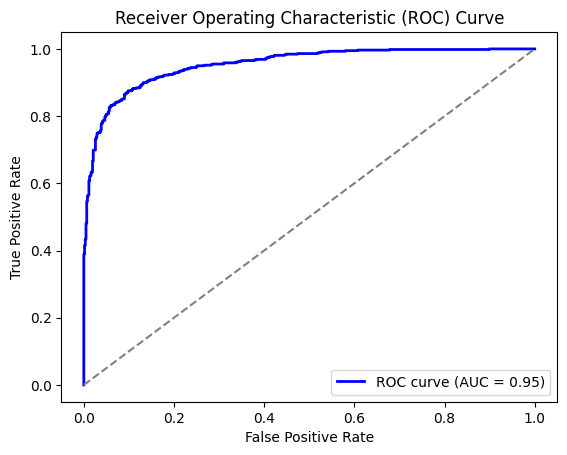

Metrics saved successfully


In [10]:
import time
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score

# Record start time for inference
start_inference_time = time.time()

# Generate predictions on test data
y_pred_proba = model.predict(X_test_preprocessed)
y_pred_binary = (y_pred_proba > 0.5).astype(int)

# Record end time for inference
end_inference_time = time.time()

# Calculate inference time
inference_time = end_inference_time - start_inference_time
print("Inference Time:", inference_time, "seconds")

# Print validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Calculate test loss and accuracy
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_encoded)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test_encoded, y_pred_proba)
print("ROC AUC Score:", roc_auc)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)
print("Confusion Matrix:")
print(conf_matrix)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)
print("Classification Report:")
print(class_report)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

kappa=cohen_kappa_score(y_test,y_pred_binary)
mcc=matthews_corrcoef(y_test,y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)


metrics={
    'Combination':'Resnet+Dense',
    'Validation Accuracy':val_accuracy*100,
    'Validation Loss':val_loss,
    'Test Accuracy':test_accuracy*100,
    'Test Loss':test_loss,
    'Training time':training_time,
    'Inference time':inference_time,
    'Cohens Kappa':kappa,
    'MCC':mcc,
    'Balanced Accuracy':balanced_accuracy
}
metrics_df=pd.DataFrame(metrics,index=[0])
metrics_df.to_csv('ResNet_4000_epoch_150_metrics.csv',index=False)
print("Metrics saved successfully")

In [11]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train_preprocessed, y_train_encoded, batch_size=32, epochs=200, 
                    validation_data=(X_val_preprocessed, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 48s 685ms/step - accuracy: 0.9699 - loss: 0.0834 - val_accuracy: 0.8893 - val_loss: 0.3252
Epoch 2/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 48s 682ms/step - accuracy: 0.9812 - loss: 0.0603 - val_accuracy: 0.8911 - val_loss: 0.3219
Epoch 3/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 48s 681ms/step - accuracy: 0.9721 - loss: 0.0709 - val_accuracy: 0.8750 - val_loss: 0.3321
Epoch 4/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 48s 682ms/step - accuracy: 0.9623 - loss: 0.0942 - val_accuracy: 0.9018 - val_loss: 0.3156
Epoch 5/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 48s 681ms/step - accuracy: 0.9679 - loss: 0.0860 - val_accuracy: 0.8946 - val_loss: 0.2822
Epoch 6/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 48s 681ms/step - accuracy: 0.9640 - loss: 0.0839 - val_accuracy: 0.8857 - val_loss: 0.3356
Epoch 7/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 48s 681ms/step - accuracy: 0.9900 - loss: 0.0400 - val_accuracy: 0.8893 - val_loss: 0.3394
Epoch 8/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 48s 680ms/step - accuracy: 0.9915 - loss: 0.0339 - 

38/38 ━━━━━━━━━━━━━━━━━━━━ 20s 532ms/step
Inference Time: 20.572105646133423 seconds
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 523ms/step - accuracy: 0.8995 - loss: 0.2650
Validation Loss: 0.28216567635536194
Validation Accuracy: 0.8946428298950195
38/38 ━━━━━━━━━━━━━━━━━━━━ 20s 533ms/step - accuracy: 0.8936 - loss: 0.3065
Test Loss: 0.3103024661540985
Test Accuracy: 0.8899999856948853
ROC AUC Score: 0.957875310139187
Confusion Matrix:
[[560  62]
 [ 70 508]]
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.90      0.89       622
           1       0.89      0.88      0.89       578

    accuracy                           0.89      1200
   macro avg       0.89      0.89      0.89      1200
weighted avg       0.89      0.89      0.89      1200



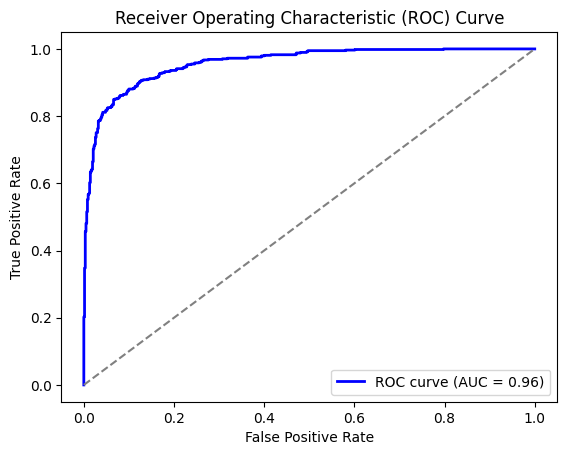

Metrics saved successfully


In [12]:
import time
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score

# Record start time for inference
start_inference_time = time.time()

# Generate predictions on test data
y_pred_proba = model.predict(X_test_preprocessed)
y_pred_binary = (y_pred_proba > 0.5).astype(int)

# Record end time for inference
end_inference_time = time.time()

# Calculate inference time
inference_time = end_inference_time - start_inference_time
print("Inference Time:", inference_time, "seconds")

# Print validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Calculate test loss and accuracy
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_encoded)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test_encoded, y_pred_proba)
print("ROC AUC Score:", roc_auc)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)
print("Confusion Matrix:")
print(conf_matrix)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)
print("Classification Report:")
print(class_report)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

kappa=cohen_kappa_score(y_test,y_pred_binary)
mcc=matthews_corrcoef(y_test,y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)

metrics={
    'Combination':'Resnet+Dense',
    'Validation Accuracy':val_accuracy*100,
    'Validation Loss':val_loss,
    'Test Accuracy':test_accuracy*100,
    'Test Loss':test_loss,
    'Training time':training_time,
    'Inference time':inference_time,
    'Cohens Kappa':kappa,
    'MCC':mcc,
    'Balanced Accuracy':balanced_accuracy
}
metrics_df=pd.DataFrame(metrics,index=[0])
metrics_df.to_csv('ResNet_4000_epoch_200_metrics.csv',index=False)
print("Metrics saved successfully")

# ResNet+Dense+Dropout

In [13]:
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout

# Load ResNet-50 model with pre-trained ImageNet weights
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array

# Preprocess the loaded images
X_train_preprocessed = np.array([img_to_array(image) for image in X_train])
X_val_preprocessed = np.array([img_to_array(image) for image in X_val])
X_test_preprocessed = np.array([img_to_array(image) for image in X_test])

# Preprocess the image data
X_train_preprocessed = tf.keras.applications.resnet50.preprocess_input(X_train_preprocessed)
X_val_preprocessed = tf.keras.applications.resnet50.preprocess_input(X_val_preprocessed)
X_test_preprocessed = tf.keras.applications.resnet50.preprocess_input(X_test_preprocessed)

# Encode the labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)  # Adding dropout for regularization
x = Dense(128, activation='relu')(x)  # Additional dense layer
predictions = Dense(1, activation='sigmoid')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,145,281 (92.11 MB)

 Trainable params: 557,569 (2.13 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [14]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train_preprocessed, y_train_encoded, batch_size=32, epochs=50, 
                    validation_data=(X_val_preprocessed, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 50s 691ms/step - accuracy: 0.6384 - loss: 0.7659 - val_accuracy: 0.7393 - val_loss: 0.5091
Epoch 2/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 47s 678ms/step - accuracy: 0.7772 - loss: 0.4722 - val_accuracy: 0.8250 - val_loss: 0.3586
Epoch 3/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 47s 678ms/step - accuracy: 0.8090 - loss: 0.4150 - val_accuracy: 0.8286 - val_loss: 0.3717
Epoch 4/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 47s 680ms/step - accuracy: 0.8271 - loss: 0.3856 - val_accuracy: 0.8411 - val_loss: 0.3339
Epoch 5/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 47s 680ms/step - accuracy: 0.8338 - loss: 0.3590 - val_accuracy: 0.8500 - val_loss: 0.3444
Epoch 6/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 47s 679ms/step - accuracy: 0.8422 - loss: 0.3475 - val_accuracy: 0.8286 - val_loss: 0.3491
Epoch 7/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 47s 679ms/step - accuracy: 0.8398 - loss: 0.3295 - val_accuracy: 0.8643 - val_loss: 0.3243
Epoch 8/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 48s 680ms/step - accuracy: 0.8645 - loss: 0.2976 - val_accu

38/38 ━━━━━━━━━━━━━━━━━━━━ 21s 548ms/step
Inference Time: 21.66662883758545 seconds
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 524ms/step - accuracy: 0.8985 - loss: 0.2703
Validation Loss: 0.2767820954322815
Validation Accuracy: 0.8892857432365417
38/38 ━━━━━━━━━━━━━━━━━━━━ 20s 534ms/step - accuracy: 0.8658 - loss: 0.2930
Test Loss: 0.2957729399204254
Test Accuracy: 0.8708333373069763
ROC AUC Score: 0.9458702811557761
Confusion Matrix:
[[558  64]
 [ 91 487]]
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.90      0.88       622
           1       0.88      0.84      0.86       578

    accuracy                           0.87      1200
   macro avg       0.87      0.87      0.87      1200
weighted avg       0.87      0.87      0.87      1200



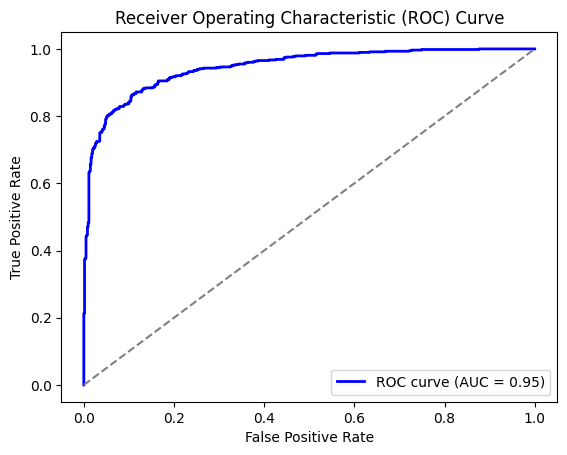

Metrics saved successfully


In [15]:
import time
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score

# Record start time for inference
start_inference_time = time.time()

# Generate predictions on test data
y_pred_proba = model.predict(X_test_preprocessed)
y_pred_binary = (y_pred_proba > 0.5).astype(int)

# Record end time for inference
end_inference_time = time.time()

# Calculate inference time
inference_time = end_inference_time - start_inference_time
print("Inference Time:", inference_time, "seconds")

# Print validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Calculate test loss and accuracy
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_encoded)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test_encoded, y_pred_proba)
print("ROC AUC Score:", roc_auc)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)
print("Confusion Matrix:")
print(conf_matrix)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)
print("Classification Report:")
print(class_report)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

kappa=cohen_kappa_score(y_test,y_pred_binary)
mcc=matthews_corrcoef(y_test,y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)

existing_metrics_df=pd.read_csv('ResNet_4000_epoch_50_metrics.csv')
metrics={
    'Combination':['Resnet+Dense+Dropout'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('ResNet_4000_epoch_50_metrics.csv',index=False)
print("Metrics saved successfully")

In [16]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train_preprocessed, y_train_encoded, batch_size=32, epochs=100, 
                    validation_data=(X_val_preprocessed, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 48s 683ms/step - accuracy: 0.9114 - loss: 0.2206 - val_accuracy: 0.8375 - val_loss: 0.3630
Epoch 2/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 47s 679ms/step - accuracy: 0.8856 - loss: 0.2580 - val_accuracy: 0.8589 - val_loss: 0.3198
Epoch 3/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 47s 679ms/step - accuracy: 0.9027 - loss: 0.2227 - val_accuracy: 0.8696 - val_loss: 0.3455
Epoch 4/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 48s 681ms/step - accuracy: 0.9067 - loss: 0.2065 - val_accuracy: 0.8768 - val_loss: 0.2936
Epoch 5/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 48s 680ms/step - accuracy: 0.8906 - loss: 0.2183 - val_accuracy: 0.8714 - val_loss: 0.3286
Epoch 6/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 48s 680ms/step - accuracy: 0.8994 - loss: 0.2025 - val_accuracy: 0.8768 - val_loss: 0.2803
Epoch 7/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 48s 680ms/step - accuracy: 0.9157 - loss: 0.2054 - val_accuracy: 0.8804 - val_loss: 0.2713
Epoch 8/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 47s 679ms/step - accuracy: 0.9023 - loss: 0.2086 - 

38/38 ━━━━━━━━━━━━━━━━━━━━ 20s 533ms/step
Inference Time: 20.62359619140625 seconds
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 524ms/step - accuracy: 0.8880 - loss: 0.2726
Validation Loss: 0.27134740352630615
Validation Accuracy: 0.8803571462631226
38/38 ━━━━━━━━━━━━━━━━━━━━ 20s 533ms/step - accuracy: 0.8767 - loss: 0.2968
Test Loss: 0.2949918806552887
Test Accuracy: 0.8799999952316284
ROC AUC Score: 0.9479035703557003
Confusion Matrix:
[[569  53]
 [ 91 487]]
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.91      0.89       622
           1       0.90      0.84      0.87       578

    accuracy                           0.88      1200
   macro avg       0.88      0.88      0.88      1200
weighted avg       0.88      0.88      0.88      1200



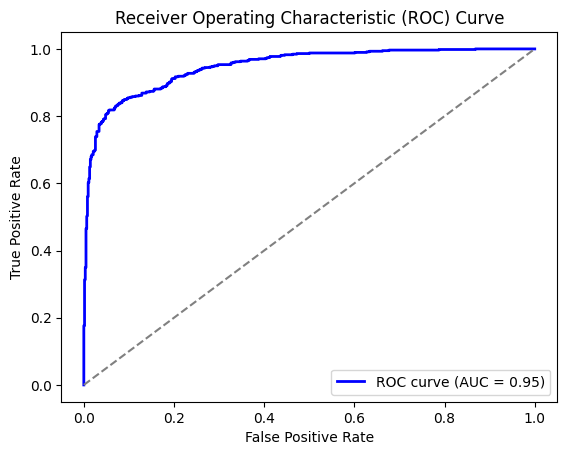

Metrics saved successfully


In [17]:
import time
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score

# Record start time for inference
start_inference_time = time.time()

# Generate predictions on test data
y_pred_proba = model.predict(X_test_preprocessed)
y_pred_binary = (y_pred_proba > 0.5).astype(int)

# Record end time for inference
end_inference_time = time.time()

# Calculate inference time
inference_time = end_inference_time - start_inference_time
print("Inference Time:", inference_time, "seconds")

# Print validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Calculate test loss and accuracy
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_encoded)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test_encoded, y_pred_proba)
print("ROC AUC Score:", roc_auc)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)
print("Confusion Matrix:")
print(conf_matrix)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)
print("Classification Report:")
print(class_report)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

kappa=cohen_kappa_score(y_test,y_pred_binary)
mcc=matthews_corrcoef(y_test,y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)

existing_metrics_df=pd.read_csv('ResNet_4000_epoch_100_metrics.csv')
metrics={
    'Combination':['Resnet+Dense+Dropout'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('ResNet_4000_epoch_100_metrics.csv',index=False)
print("Metrics saved successfully")

In [18]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train_preprocessed, y_train_encoded, batch_size=32, epochs=150, 
                    validation_data=(X_val_preprocessed, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/150
70/70 ━━━━━━━━━━━━━━━━━━━━ 48s 682ms/step - accuracy: 0.9159 - loss: 0.1904 - val_accuracy: 0.8875 - val_loss: 0.2745
Epoch 2/150
70/70 ━━━━━━━━━━━━━━━━━━━━ 48s 682ms/step - accuracy: 0.9152 - loss: 0.1764 - val_accuracy: 0.8768 - val_loss: 0.2928
Epoch 3/150
70/70 ━━━━━━━━━━━━━━━━━━━━ 48s 681ms/step - accuracy: 0.9049 - loss: 0.2185 - val_accuracy: 0.8839 - val_loss: 0.2868
Epoch 4/150
70/70 ━━━━━━━━━━━━━━━━━━━━ 48s 681ms/step - accuracy: 0.9002 - loss: 0.2268 - val_accuracy: 0.8696 - val_loss: 0.3304
Epoch 5/150
70/70 ━━━━━━━━━━━━━━━━━━━━ 48s 680ms/step - accuracy: 0.9072 - loss: 0.2156 - val_accuracy: 0.8714 - val_loss: 0.3024
Epoch 6/150
70/70 ━━━━━━━━━━━━━━━━━━━━ 48s 681ms/step - accuracy: 0.9058 - loss: 0.2273 - val_accuracy: 0.8875 - val_loss: 0.2960
Training Time: 286.099821805954 seconds


38/38 ━━━━━━━━━━━━━━━━━━━━ 20s 535ms/step
Inference Time: 20.695219039916992 seconds
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 525ms/step - accuracy: 0.8911 - loss: 0.2577
Validation Loss: 0.27448827028274536
Validation Accuracy: 0.887499988079071
38/38 ━━━━━━━━━━━━━━━━━━━━ 20s 536ms/step - accuracy: 0.8798 - loss: 0.2956
Test Loss: 0.2971433699131012
Test Accuracy: 0.878333330154419
ROC AUC Score: 0.9465489713948754
Confusion Matrix:
[[561  61]
 [ 85 493]]
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.90      0.88       622
           1       0.89      0.85      0.87       578

    accuracy                           0.88      1200
   macro avg       0.88      0.88      0.88      1200
weighted avg       0.88      0.88      0.88      1200



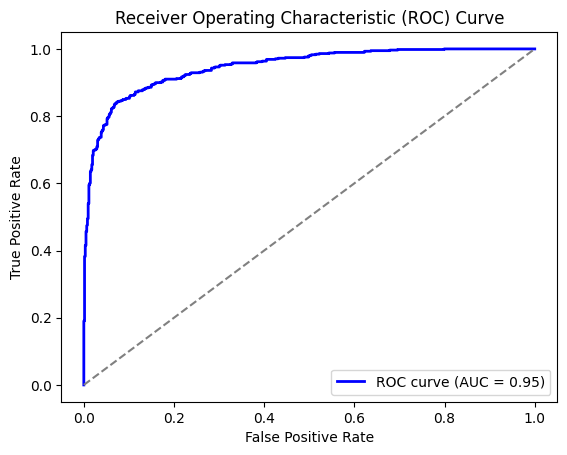

Metrics saved successfully


In [19]:
import time
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score

# Record start time for inference
start_inference_time = time.time()

# Generate predictions on test data
y_pred_proba = model.predict(X_test_preprocessed)
y_pred_binary = (y_pred_proba > 0.5).astype(int)

# Record end time for inference
end_inference_time = time.time()

# Calculate inference time
inference_time = end_inference_time - start_inference_time
print("Inference Time:", inference_time, "seconds")

# Print validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Calculate test loss and accuracy
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_encoded)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test_encoded, y_pred_proba)
print("ROC AUC Score:", roc_auc)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)
print("Confusion Matrix:")
print(conf_matrix)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)
print("Classification Report:")
print(class_report)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

kappa=cohen_kappa_score(y_test,y_pred_binary)
mcc=matthews_corrcoef(y_test,y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)

existing_metrics_df=pd.read_csv('ResNet_4000_epoch_150_metrics.csv')
metrics={
    'Combination':['Resnet+Dense+Dropout'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('ResNet_4000_epoch_150_metrics.csv',index=False)
print("Metrics saved successfully")

In [20]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train_preprocessed, y_train_encoded, batch_size=32, epochs=200, 
                    validation_data=(X_val_preprocessed, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 48s 686ms/step - accuracy: 0.9125 - loss: 0.1955 - val_accuracy: 0.8786 - val_loss: 0.3010
Epoch 2/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 48s 681ms/step - accuracy: 0.8995 - loss: 0.2311 - val_accuracy: 0.8661 - val_loss: 0.2875
Epoch 3/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 48s 680ms/step - accuracy: 0.8794 - loss: 0.2406 - val_accuracy: 0.8768 - val_loss: 0.2935
Epoch 4/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 48s 681ms/step - accuracy: 0.8918 - loss: 0.2182 - val_accuracy: 0.8679 - val_loss: 0.2928
Epoch 5/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 48s 680ms/step - accuracy: 0.8999 - loss: 0.2148 - val_accuracy: 0.8875 - val_loss: 0.2783
Epoch 6/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 48s 681ms/step - accuracy: 0.9044 - loss: 0.2335 - val_accuracy: 0.8821 - val_loss: 0.2836
Epoch 7/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 48s 681ms/step - accuracy: 0.9146 - loss: 0.1852 - val_accuracy: 0.8750 - val_loss: 0.3021
Epoch 8/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 48s 681ms/step - accuracy: 0.8949 - loss: 0.2221 - 

38/38 ━━━━━━━━━━━━━━━━━━━━ 20s 533ms/step
Inference Time: 20.59263777732849 seconds
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 524ms/step - accuracy: 0.8916 - loss: 0.2757
Validation Loss: 0.27827611565589905
Validation Accuracy: 0.887499988079071
38/38 ━━━━━━━━━━━━━━━━━━━━ 20s 533ms/step - accuracy: 0.8776 - loss: 0.3046
Test Loss: 0.3084154725074768
Test Accuracy: 0.8816666603088379
ROC AUC Score: 0.94747243516283
Confusion Matrix:
[[582  40]
 [102 476]]
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.94      0.89       622
           1       0.92      0.82      0.87       578

    accuracy                           0.88      1200
   macro avg       0.89      0.88      0.88      1200
weighted avg       0.89      0.88      0.88      1200



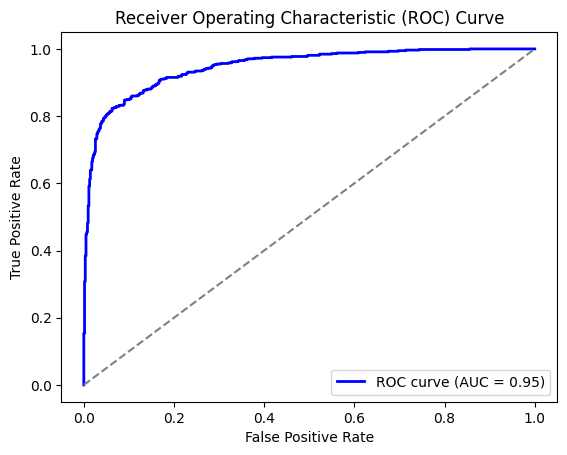

Metrics saved successfully


In [21]:
import time
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score

# Record start time for inference
start_inference_time = time.time()

# Generate predictions on test data
y_pred_proba = model.predict(X_test_preprocessed)
y_pred_binary = (y_pred_proba > 0.5).astype(int)

# Record end time for inference
end_inference_time = time.time()

# Calculate inference time
inference_time = end_inference_time - start_inference_time
print("Inference Time:", inference_time, "seconds")

# Print validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Calculate test loss and accuracy
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_encoded)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test_encoded, y_pred_proba)
print("ROC AUC Score:", roc_auc)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)
print("Confusion Matrix:")
print(conf_matrix)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)
print("Classification Report:")
print(class_report)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

kappa=cohen_kappa_score(y_test,y_pred_binary)
mcc=matthews_corrcoef(y_test,y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)

existing_metrics_df=pd.read_csv('ResNet_4000_epoch_200_metrics.csv')
metrics={
    'Combination':['Resnet+Dense+Dropout'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('ResNet_4000_epoch_200_metrics.csv',index=False)
print("Metrics saved successfully")

# ResNet+Conv2D+GlobalAveragePooling+Dropout+Dense

In [22]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder

import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array

# Preprocess the loaded images
X_train_preprocessed = np.array([img_to_array(image) for image in X_train])
X_val_preprocessed = np.array([img_to_array(image) for image in X_val])
X_test_preprocessed = np.array([img_to_array(image) for image in X_test])

# Preprocess the image data
X_train_preprocessed = tf.keras.applications.resnet50.preprocess_input(X_train_preprocessed)
X_val_preprocessed = tf.keras.applications.resnet50.preprocess_input(X_val_preprocessed)
X_test_preprocessed = tf.keras.applications.resnet50.preprocess_input(X_test_preprocessed)

# Encode the labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

# Load ResNet-50 model with pre-trained ImageNet weights
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add additional layers
x = base_model.output
x = Conv2D(64, (3, 3), activation='relu')(x)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_2[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,784,321 (94.54 MB)

 Trainable params: 1,196,609 (4.56 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [23]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train_preprocessed, y_train_encoded, batch_size=32, epochs=50, 
                    validation_data=(X_val_preprocessed, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 51s 699ms/step - accuracy: 0.5996 - loss: 0.8515 - val_accuracy: 0.8179 - val_loss: 0.3956
Epoch 2/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 48s 690ms/step - accuracy: 0.7619 - loss: 0.4681 - val_accuracy: 0.8250 - val_loss: 0.3580
Epoch 3/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 48s 688ms/step - accuracy: 0.7813 - loss: 0.4089 - val_accuracy: 0.8554 - val_loss: 0.3572
Epoch 4/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 48s 688ms/step - accuracy: 0.8228 - loss: 0.3788 - val_accuracy: 0.8554 - val_loss: 0.3368
Epoch 5/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 48s 689ms/step - accuracy: 0.8408 - loss: 0.3283 - val_accuracy: 0.8500 - val_loss: 0.3161
Epoch 6/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 48s 688ms/step - accuracy: 0.8259 - loss: 0.3411 - val_accuracy: 0.8643 - val_loss: 0.3054
Epoch 7/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 48s 688ms/step - accuracy: 0.8451 - loss: 0.3150 - val_accuracy: 0.8875 - val_loss: 0.2909
Epoch 8/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 48s 688ms/step - accuracy: 0.8538 - loss: 0.2986 - val_accu

38/38 ━━━━━━━━━━━━━━━━━━━━ 22s 551ms/step
Inference Time: 22.16226816177368 seconds
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 527ms/step - accuracy: 0.8597 - loss: 0.2842
Validation Loss: 0.28060826659202576
Validation Accuracy: 0.8732143044471741
38/38 ━━━━━━━━━━━━━━━━━━━━ 20s 536ms/step - accuracy: 0.8633 - loss: 0.3139
Test Loss: 0.30978769063949585
Test Accuracy: 0.8675000071525574
ROC AUC Score: 0.9477478053827925
Confusion Matrix:
[[588  34]
 [125 453]]
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.95      0.88       622
           1       0.93      0.78      0.85       578

    accuracy                           0.87      1200
   macro avg       0.88      0.86      0.87      1200
weighted avg       0.88      0.87      0.87      1200



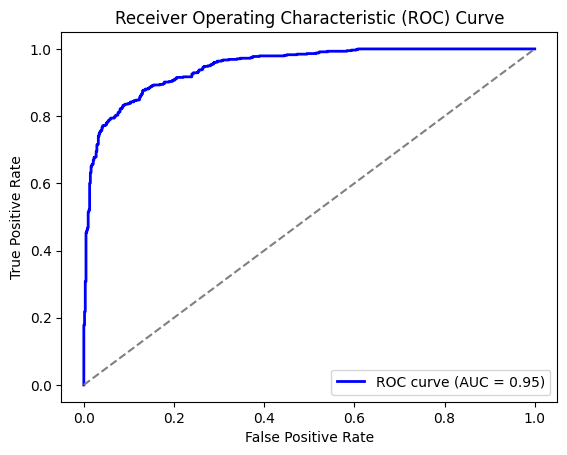

Metrics saved successfully


In [24]:
import time
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.metrics import cohen_kappa_score, matthews_corrcoef, balanced_accuracy_score

# Record start time for inference
start_inference_time = time.time()

# Generate predictions on test data
y_pred_proba = model.predict(X_test_preprocessed)
y_pred_binary = (y_pred_proba > 0.5).astype(int)

# Record end time for inference
end_inference_time = time.time()

# Calculate inference time
inference_time = end_inference_time - start_inference_time
print("Inference Time:", inference_time, "seconds")

# Print validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Calculate test loss and accuracy
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_encoded)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test_encoded, y_pred_proba)
print("ROC AUC Score:", roc_auc)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)
print("Confusion Matrix:")
print(conf_matrix)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)
print("Classification Report:")
print(class_report)

kappa=cohen_kappa_score(y_test,y_pred_binary)
mcc=matthews_corrcoef(y_test,y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

existing_metrics_df=pd.read_csv('ResNet_4000_epoch_50_metrics.csv')
metrics={
    'Combination':['ResNet+Conv2D+GlobalAveragePooling+Dropout+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('ResNet_4000_epoch_50_metrics.csv',index=False)
print("Metrics saved successfully")

In [25]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train_preprocessed, y_train_encoded, batch_size=32, epochs=100, 
                    validation_data=(X_val_preprocessed, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 48s 691ms/step - accuracy: 0.8507 - loss: 0.2805 - val_accuracy: 0.8821 - val_loss: 0.2943
Epoch 2/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 48s 690ms/step - accuracy: 0.8785 - loss: 0.2680 - val_accuracy: 0.8661 - val_loss: 0.3106
Epoch 3/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 48s 688ms/step - accuracy: 0.8782 - loss: 0.2551 - val_accuracy: 0.8839 - val_loss: 0.3022
Epoch 4/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 48s 688ms/step - accuracy: 0.8951 - loss: 0.2269 - val_accuracy: 0.8857 - val_loss: 0.2644
Epoch 5/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 48s 688ms/step - accuracy: 0.8935 - loss: 0.2178 - val_accuracy: 0.8929 - val_loss: 0.2518
Epoch 6/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 48s 688ms/step - accuracy: 0.8940 - loss: 0.2085 - val_accuracy: 0.8821 - val_loss: 0.2844
Epoch 7/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 48s 687ms/step - accuracy: 0.9209 - loss: 0.1708 - val_accuracy: 0.8821 - val_loss: 0.3281
Epoch 8/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 48s 690ms/step - accuracy: 0.9129 - loss: 0.2075 - 

38/38 ━━━━━━━━━━━━━━━━━━━━ 20s 537ms/step
Inference Time: 20.764368772506714 seconds
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 528ms/step - accuracy: 0.8841 - loss: 0.2456
Validation Loss: 0.2518366873264313
Validation Accuracy: 0.8928571343421936
38/38 ━━━━━━━━━━━━━━━━━━━━ 20s 537ms/step - accuracy: 0.8909 - loss: 0.2968
Test Loss: 0.2857714891433716
Test Accuracy: 0.8916666507720947
ROC AUC Score: 0.9568795269195252
Confusion Matrix:
[[560  62]
 [ 68 510]]
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.90      0.90       622
           1       0.89      0.88      0.89       578

    accuracy                           0.89      1200
   macro avg       0.89      0.89      0.89      1200
weighted avg       0.89      0.89      0.89      1200



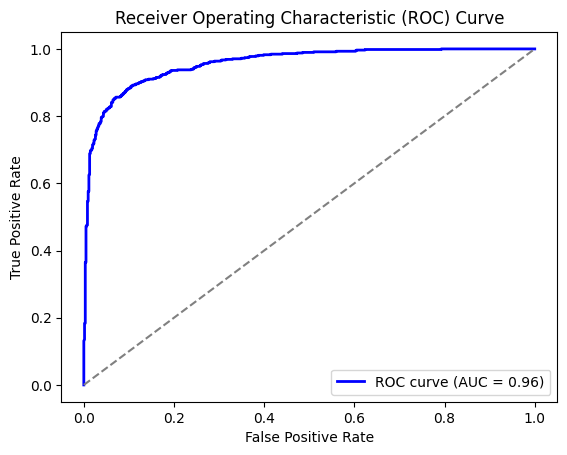

Metrics saved successfully


In [26]:
import time
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score

# Record start time for inference
start_inference_time = time.time()

# Generate predictions on test data
y_pred_proba = model.predict(X_test_preprocessed)
y_pred_binary = (y_pred_proba > 0.5).astype(int)

# Record end time for inference
end_inference_time = time.time()

# Calculate inference time
inference_time = end_inference_time - start_inference_time
print("Inference Time:", inference_time, "seconds")

# Print validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Calculate test loss and accuracy
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_encoded)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test_encoded, y_pred_proba)
print("ROC AUC Score:", roc_auc)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)
print("Confusion Matrix:")
print(conf_matrix)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)
print("Classification Report:")
print(class_report)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

kappa=cohen_kappa_score(y_test,y_pred_binary)
mcc=matthews_corrcoef(y_test,y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)

existing_metrics_df=pd.read_csv('ResNet_4000_epoch_100_metrics.csv')
metrics={
    'Combination':['ResNet+Conv2D+GlobalAveragePooling+Dropout+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('ResNet_4000_epoch_100_metrics.csv',index=False)
print("Metrics saved successfully")

In [27]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train_preprocessed, y_train_encoded, batch_size=32, epochs=150, 
                    validation_data=(X_val_preprocessed, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/150
70/70 ━━━━━━━━━━━━━━━━━━━━ 48s 693ms/step - accuracy: 0.9049 - loss: 0.2104 - val_accuracy: 0.8946 - val_loss: 0.2670
Epoch 2/150
70/70 ━━━━━━━━━━━━━━━━━━━━ 48s 687ms/step - accuracy: 0.9075 - loss: 0.2009 - val_accuracy: 0.8875 - val_loss: 0.3044
Epoch 3/150
70/70 ━━━━━━━━━━━━━━━━━━━━ 48s 688ms/step - accuracy: 0.9098 - loss: 0.1949 - val_accuracy: 0.8929 - val_loss: 0.2672
Epoch 4/150
70/70 ━━━━━━━━━━━━━━━━━━━━ 48s 688ms/step - accuracy: 0.9035 - loss: 0.1784 - val_accuracy: 0.8804 - val_loss: 0.2737
Epoch 5/150
70/70 ━━━━━━━━━━━━━━━━━━━━ 48s 687ms/step - accuracy: 0.9190 - loss: 0.1743 - val_accuracy: 0.8857 - val_loss: 0.3119
Epoch 6/150
70/70 ━━━━━━━━━━━━━━━━━━━━ 48s 688ms/step - accuracy: 0.9079 - loss: 0.2014 - val_accuracy: 0.8964 - val_loss: 0.2848
Training Time: 289.23476815223694 seconds


38/38 ━━━━━━━━━━━━━━━━━━━━ 20s 538ms/step
Inference Time: 20.782550573349 seconds
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 527ms/step - accuracy: 0.8923 - loss: 0.2528
Validation Loss: 0.2670014798641205
Validation Accuracy: 0.8946428298950195
38/38 ━━━━━━━━━━━━━━━━━━━━ 20s 538ms/step - accuracy: 0.8799 - loss: 0.3107
Test Loss: 0.30328935384750366
Test Accuracy: 0.8808333277702332
ROC AUC Score: 0.9560478532248913
Confusion Matrix:
[[556  66]
 [ 77 501]]
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.89      0.89       622
           1       0.88      0.87      0.88       578

    accuracy                           0.88      1200
   macro avg       0.88      0.88      0.88      1200
weighted avg       0.88      0.88      0.88      1200



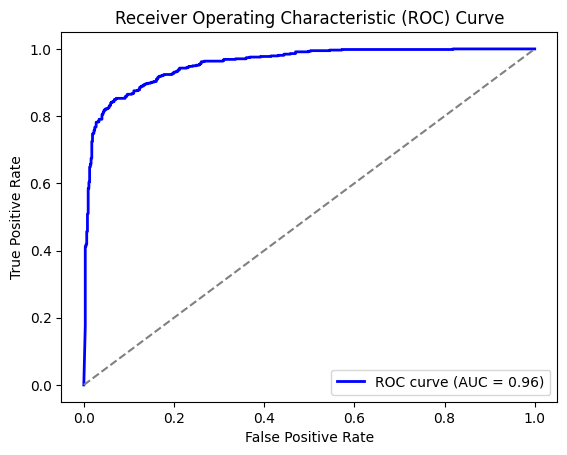

Metrics saved successfully


In [28]:
import time
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score

# Record start time for inference
start_inference_time = time.time()

# Generate predictions on test data
y_pred_proba = model.predict(X_test_preprocessed)
y_pred_binary = (y_pred_proba > 0.5).astype(int)

# Record end time for inference
end_inference_time = time.time()

# Calculate inference time
inference_time = end_inference_time - start_inference_time
print("Inference Time:", inference_time, "seconds")

# Print validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Calculate test loss and accuracy
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_encoded)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test_encoded, y_pred_proba)
print("ROC AUC Score:", roc_auc)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)
print("Confusion Matrix:")
print(conf_matrix)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)
print("Classification Report:")
print(class_report)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

kappa=cohen_kappa_score(y_test,y_pred_binary)
mcc=matthews_corrcoef(y_test,y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)

existing_metrics_df=pd.read_csv('ResNet_4000_epoch_150_metrics.csv')
metrics={
    'Combination':['ResNet+Conv2D+GlobalAveragePooling+Dropout+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('ResNet_4000_epoch_150_metrics.csv',index=False)
print("Metrics saved successfully")

In [29]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train_preprocessed, y_train_encoded, batch_size=32, epochs=200, 
                    validation_data=(X_val_preprocessed, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 48s 693ms/step - accuracy: 0.9083 - loss: 0.1949 - val_accuracy: 0.8750 - val_loss: 0.3230
Epoch 2/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 48s 690ms/step - accuracy: 0.9127 - loss: 0.2070 - val_accuracy: 0.8982 - val_loss: 0.2653
Epoch 3/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 48s 687ms/step - accuracy: 0.9163 - loss: 0.1840 - val_accuracy: 0.8839 - val_loss: 0.3391
Epoch 4/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 48s 691ms/step - accuracy: 0.9340 - loss: 0.1600 - val_accuracy: 0.9000 - val_loss: 0.3736
Epoch 5/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 48s 690ms/step - accuracy: 0.9345 - loss: 0.1476 - val_accuracy: 0.8946 - val_loss: 0.3003
Epoch 6/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 48s 687ms/step - accuracy: 0.9202 - loss: 0.1822 - val_accuracy: 0.8661 - val_loss: 0.3797
Epoch 7/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 48s 687ms/step - accuracy: 0.9359 - loss: 0.1618 - val_accuracy: 0.8750 - val_loss: 0.3933
Training Time: 337.67475938796997 seconds


38/38 ━━━━━━━━━━━━━━━━━━━━ 20s 535ms/step
Inference Time: 20.70437979698181 seconds
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 525ms/step - accuracy: 0.8871 - loss: 0.2536
Validation Loss: 0.26530954241752625
Validation Accuracy: 0.8982142806053162
38/38 ━━━━━━━━━━━━━━━━━━━━ 20s 537ms/step - accuracy: 0.9019 - loss: 0.2990
Test Loss: 0.29526081681251526
Test Accuracy: 0.8966666460037231
ROC AUC Score: 0.9561938828869926
Confusion Matrix:
[[576  46]
 [ 78 500]]
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.93      0.90       622
           1       0.92      0.87      0.89       578

    accuracy                           0.90      1200
   macro avg       0.90      0.90      0.90      1200
weighted avg       0.90      0.90      0.90      1200



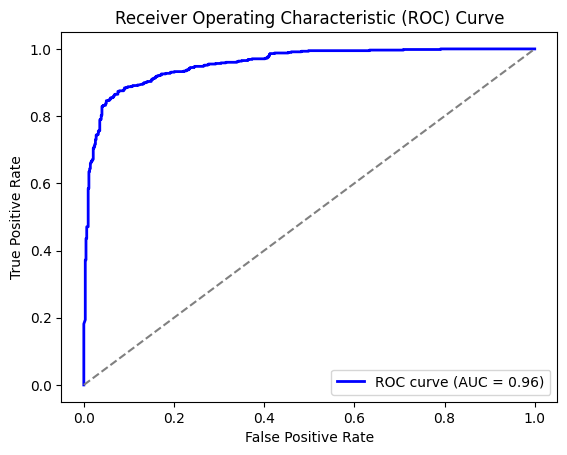

Metrics saved successfully


In [30]:
import time
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score

# Record start time for inference
start_inference_time = time.time()

# Generate predictions on test data
y_pred_proba = model.predict(X_test_preprocessed)
y_pred_binary = (y_pred_proba > 0.5).astype(int)

# Record end time for inference
end_inference_time = time.time()

# Calculate inference time
inference_time = end_inference_time - start_inference_time
print("Inference Time:", inference_time, "seconds")

# Print validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Calculate test loss and accuracy
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_encoded)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test_encoded, y_pred_proba)
print("ROC AUC Score:", roc_auc)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)
print("Confusion Matrix:")
print(conf_matrix)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)
print("Classification Report:")
print(class_report)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

kappa=cohen_kappa_score(y_test,y_pred_binary)
mcc=matthews_corrcoef(y_test,y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)

existing_metrics_df=pd.read_csv('ResNet_4000_epoch_200_metrics.csv')
metrics={
    'Combination':['ResNet+Conv2D+GlobalAveragePooling+Dropout+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('ResNet_4000_epoch_200_metrics.csv',index=False)
print("Metrics saved successfully")

# ResNet+LSTM+Dense

In [31]:
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense, Flatten
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder

import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array

# Preprocess the loaded images
X_train_preprocessed = np.array([img_to_array(image) for image in X_train])
X_val_preprocessed = np.array([img_to_array(image) for image in X_val])
X_test_preprocessed = np.array([img_to_array(image) for image in X_test])

# Preprocess the image data
X_train_preprocessed = tf.keras.applications.resnet50.preprocess_input(X_train_preprocessed)
X_val_preprocessed = tf.keras.applications.resnet50.preprocess_input(X_val_preprocessed)
X_test_preprocessed = tf.keras.applications.resnet50.preprocess_input(X_test_preprocessed)

# Encode the labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

# Load ResNet-50 model with pre-trained ImageNet weights
resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
for layer in resnet_base.layers:
    layer.trainable = False

# Extract features using ResNet
resnet_output = resnet_base.output
flattened_output = Flatten()(resnet_output)

# Reshape features for LSTM
reshaped_output = tf.keras.layers.Reshape((1, flattened_output.shape[1]))(flattened_output)

# LSTM layer
lstm_output = LSTM(128)(reshaped_output)

# Dense layer for classification
dense_output = Dense(64, activation='relu')(lstm_output)
predictions = Dense(1, activation='sigmoid')(dense_output)

# Create the model
model = Model(inputs=resnet_base.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_3[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 75,042,305 (286.26 MB)

 Trainable params: 51,454,593 (196.28 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [32]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train_preprocessed, y_train_encoded, batch_size=32, epochs=50, 
                    validation_data=(X_val_preprocessed, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 70s 974ms/step - accuracy: 0.6110 - loss: 0.6569 - val_accuracy: 0.7321 - val_loss: 0.5642
Epoch 2/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 67s 955ms/step - accuracy: 0.7247 - loss: 0.5531 - val_accuracy: 0.6929 - val_loss: 0.5849
Epoch 3/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 67s 958ms/step - accuracy: 0.7549 - loss: 0.5019 - val_accuracy: 0.7071 - val_loss: 0.5371
Epoch 4/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 67s 957ms/step - accuracy: 0.7735 - loss: 0.4805 - val_accuracy: 0.7571 - val_loss: 0.5152
Epoch 5/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 67s 958ms/step - accuracy: 0.8052 - loss: 0.4226 - val_accuracy: 0.7661 - val_loss: 0.4732
Epoch 6/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 67s 958ms/step - accuracy: 0.7867 - loss: 0.4371 - val_accuracy: 0.7821 - val_loss: 0.4507
Epoch 7/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 67s 957ms/step - accuracy: 0.8179 - loss: 0.3912 - val_accuracy: 0.7911 - val_loss: 0.4354
Epoch 8/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 67s 956ms/step - accuracy: 0.8293 - loss: 0.3938 - val_accu

38/38 ━━━━━━━━━━━━━━━━━━━━ 22s 561ms/step
Inference Time: 22.220300436019897 seconds
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 535ms/step - accuracy: 0.8030 - loss: 0.4190
Validation Loss: 0.41501858830451965
Validation Accuracy: 0.8071428537368774
38/38 ━━━━━━━━━━━━━━━━━━━━ 21s 544ms/step - accuracy: 0.8430 - loss: 0.4025
Test Loss: 0.42089104652404785
Test Accuracy: 0.82833331823349
ROC AUC Score: 0.8900619165767308
Confusion Matrix:
[[545  77]
 [129 449]]
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.88      0.84       622
           1       0.85      0.78      0.81       578

    accuracy                           0.83      1200
   macro avg       0.83      0.83      0.83      1200
weighted avg       0.83      0.83      0.83      1200



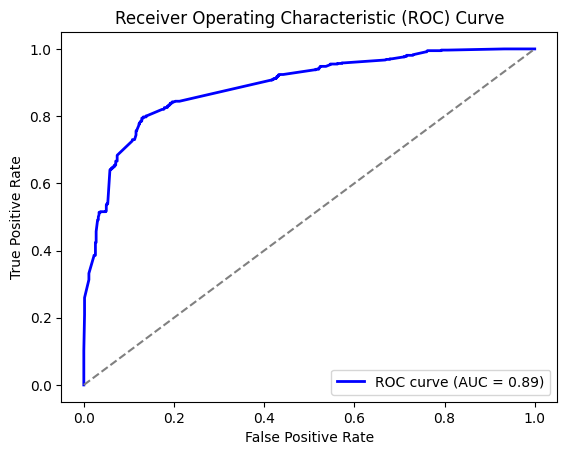

Metrics saved successfully


In [33]:
import time
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_scorebalanced_accuracy_score

# Record start time for inference
start_inference_time = time.time()

# Generate predictions on test data
y_pred_proba = model.predict(X_test_preprocessed)
y_pred_binary = (y_pred_proba > 0.5).astype(int)

# Record end time for inference
end_inference_time = time.time()

# Calculate inference time
inference_time = end_inference_time - start_inference_time
print("Inference Time:", inference_time, "seconds")

# Print validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Calculate test loss and accuracy
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_encoded)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test_encoded, y_pred_proba)
print("ROC AUC Score:", roc_auc)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)
print("Confusion Matrix:")
print(conf_matrix)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)
print("Classification Report:")
print(class_report)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

kappa=cohen_kappa_score(y_test,y_pred_binary)
mcc=matthews_corrcoef(y_test,y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)

existing_metrics_df=pd.read_csv('ResNet_4000_epoch_50_metrics.csv')
metrics={
    'Combination':['ResNet+LSTM+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('ResNet_4000_epoch_50_metrics.csv',index=False)
print("Metrics saved successfully")


In [34]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train_preprocessed, y_train_encoded, batch_size=32, epochs=100, 
                    validation_data=(X_val_preprocessed, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 67s 959ms/step - accuracy: 0.8315 - loss: 0.3806 - val_accuracy: 0.7893 - val_loss: 0.4516
Epoch 2/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 67s 953ms/step - accuracy: 0.8030 - loss: 0.4335 - val_accuracy: 0.7821 - val_loss: 0.4249
Epoch 3/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 67s 963ms/step - accuracy: 0.8085 - loss: 0.4002 - val_accuracy: 0.8286 - val_loss: 0.4017
Epoch 4/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 67s 956ms/step - accuracy: 0.8308 - loss: 0.3813 - val_accuracy: 0.7393 - val_loss: 0.5047
Epoch 5/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 67s 955ms/step - accuracy: 0.7672 - loss: 0.4550 - val_accuracy: 0.8089 - val_loss: 0.4642
Epoch 6/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 67s 956ms/step - accuracy: 0.8164 - loss: 0.4107 - val_accuracy: 0.8321 - val_loss: 0.4143
Epoch 7/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 67s 956ms/step - accuracy: 0.8252 - loss: 0.4159 - val_accuracy: 0.7536 - val_loss: 0.4758
Epoch 8/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 67s 955ms/step - accuracy: 0.7909 - loss: 0.4253 - 

38/38 ━━━━━━━━━━━━━━━━━━━━ 21s 544ms/step
Inference Time: 21.014223337173462 seconds
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 535ms/step - accuracy: 0.8431 - loss: 0.3954
Validation Loss: 0.4017328917980194
Validation Accuracy: 0.8285714387893677
38/38 ━━━━━━━━━━━━━━━━━━━━ 21s 544ms/step - accuracy: 0.8150 - loss: 0.4104
Test Loss: 0.41157013177871704
Test Accuracy: 0.8149999976158142
ROC AUC Score: 0.8969378275236708
Confusion Matrix:
[[493 129]
 [ 93 485]]
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.79      0.82       622
           1       0.79      0.84      0.81       578

    accuracy                           0.81      1200
   macro avg       0.82      0.82      0.81      1200
weighted avg       0.82      0.81      0.82      1200



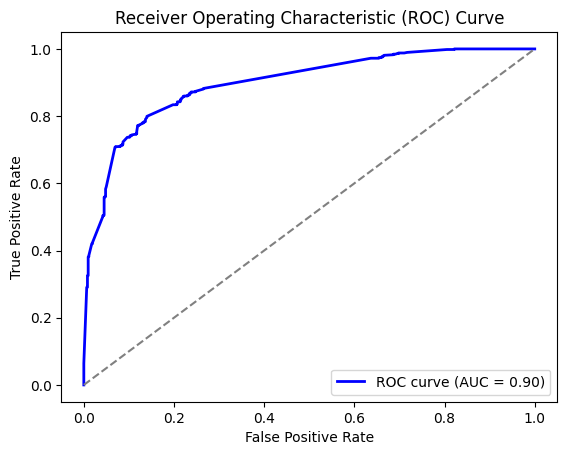

Metrics saved successfully


In [35]:
import time
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score

# Record start time for inference
start_inference_time = time.time()

# Generate predictions on test data
y_pred_proba = model.predict(X_test_preprocessed)
y_pred_binary = (y_pred_proba > 0.5).astype(int)

# Record end time for inference
end_inference_time = time.time()

# Calculate inference time
inference_time = end_inference_time - start_inference_time
print("Inference Time:", inference_time, "seconds")

# Print validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Calculate test loss and accuracy
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_encoded)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test_encoded, y_pred_proba)
print("ROC AUC Score:", roc_auc)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)
print("Confusion Matrix:")
print(conf_matrix)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)
print("Classification Report:")
print(class_report)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

kappa=cohen_kappa_score(y_test,y_pred_binary)
mcc=matthews_corrcoef(y_test,y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)

existing_metrics_df=pd.read_csv('ResNet_4000_epoch_100_metrics.csv')
metrics={
    'Combination':['ResNet+LSTM+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('ResNet_4000_epoch_100_metrics.csv',index=False)
print("Metrics saved successfully")

In [36]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train_preprocessed, y_train_encoded, batch_size=32, epochs=150, 
                    validation_data=(X_val_preprocessed, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/150
70/70 ━━━━━━━━━━━━━━━━━━━━ 67s 958ms/step - accuracy: 0.8393 - loss: 0.3699 - val_accuracy: 0.8107 - val_loss: 0.4254
Epoch 2/150
70/70 ━━━━━━━━━━━━━━━━━━━━ 67s 953ms/step - accuracy: 0.8323 - loss: 0.3618 - val_accuracy: 0.7536 - val_loss: 0.4646
Epoch 3/150
70/70 ━━━━━━━━━━━━━━━━━━━━ 67s 954ms/step - accuracy: 0.7915 - loss: 0.4151 - val_accuracy: 0.8179 - val_loss: 0.4133
Epoch 4/150
70/70 ━━━━━━━━━━━━━━━━━━━━ 67s 955ms/step - accuracy: 0.8002 - loss: 0.4077 - val_accuracy: 0.8054 - val_loss: 0.4079
Epoch 5/150
70/70 ━━━━━━━━━━━━━━━━━━━━ 67s 955ms/step - accuracy: 0.8439 - loss: 0.3320 - val_accuracy: 0.8054 - val_loss: 0.4475
Epoch 6/150
70/70 ━━━━━━━━━━━━━━━━━━━━ 67s 953ms/step - accuracy: 0.8089 - loss: 0.4108 - val_accuracy: 0.8143 - val_loss: 0.4874
Epoch 7/150
70/70 ━━━━━━━━━━━━━━━━━━━━ 67s 954ms/step - accuracy: 0.8496 - loss: 0.3349 - val_accuracy: 0.8268 - val_loss: 0.4199
Epoch 8/150
70/70 ━━━━━━━━━━━━━━━━━━━━ 67s 954ms/step - accuracy: 0.8642 - loss: 0.3313 - 

38/38 ━━━━━━━━━━━━━━━━━━━━ 21s 545ms/step
Inference Time: 21.072802543640137 seconds
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 535ms/step - accuracy: 0.8541 - loss: 0.3780
Validation Loss: 0.3769584596157074
Validation Accuracy: 0.8535714149475098
38/38 ━━━━━━━━━━━━━━━━━━━━ 21s 545ms/step - accuracy: 0.8409 - loss: 0.4068
Test Loss: 0.43123340606689453
Test Accuracy: 0.8324999809265137
ROC AUC Score: 0.8824085715239377
Confusion Matrix:
[[524  98]
 [103 475]]
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.84      0.84       622
           1       0.83      0.82      0.83       578

    accuracy                           0.83      1200
   macro avg       0.83      0.83      0.83      1200
weighted avg       0.83      0.83      0.83      1200



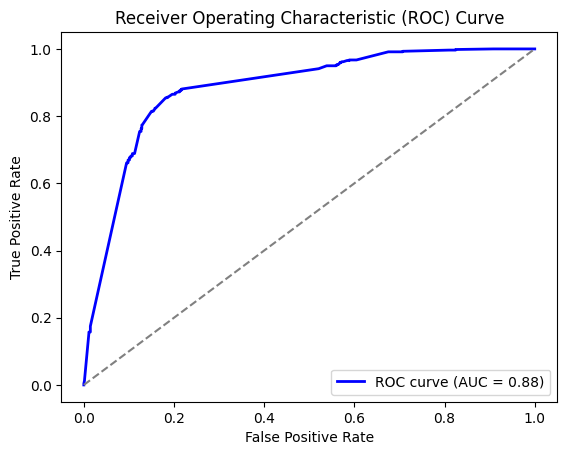

Metrics saved successfully


In [37]:
import time
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score

# Record start time for inference
start_inference_time = time.time()

# Generate predictions on test data
y_pred_proba = model.predict(X_test_preprocessed)
y_pred_binary = (y_pred_proba > 0.5).astype(int)

# Record end time for inference
end_inference_time = time.time()

# Calculate inference time
inference_time = end_inference_time - start_inference_time
print("Inference Time:", inference_time, "seconds")

# Print validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Calculate test loss and accuracy
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_encoded)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test_encoded, y_pred_proba)
print("ROC AUC Score:", roc_auc)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)
print("Confusion Matrix:")
print(conf_matrix)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)
print("Classification Report:")
print(class_report)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

kappa=cohen_kappa_score(y_test,y_pred_binary)
mcc=matthews_corrcoef(y_test,y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)

existing_metrics_df=pd.read_csv('ResNet_4000_epoch_150_metrics.csv')
metrics={
    'Combination':['ResNet+LSTM+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('ResNet_4000_epoch_150_metrics.csv',index=False)
print("Metrics saved successfully")

In [38]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train_preprocessed, y_train_encoded, batch_size=32, epochs=200, 
                    validation_data=(X_val_preprocessed, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 67s 960ms/step - accuracy: 0.8489 - loss: 0.3471 - val_accuracy: 0.8464 - val_loss: 0.3948
Epoch 2/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 67s 956ms/step - accuracy: 0.8812 - loss: 0.3182 - val_accuracy: 0.7946 - val_loss: 0.4443
Epoch 3/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 67s 955ms/step - accuracy: 0.8877 - loss: 0.2632 - val_accuracy: 0.8518 - val_loss: 0.3665
Epoch 4/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 67s 956ms/step - accuracy: 0.8914 - loss: 0.2725 - val_accuracy: 0.8214 - val_loss: 0.3764
Epoch 5/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 67s 956ms/step - accuracy: 0.8833 - loss: 0.2868 - val_accuracy: 0.7911 - val_loss: 0.4505
Epoch 6/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 67s 956ms/step - accuracy: 0.8638 - loss: 0.3334 - val_accuracy: 0.8679 - val_loss: 0.3488
Epoch 7/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 67s 955ms/step - accuracy: 0.9092 - loss: 0.2784 - val_accuracy: 0.8250 - val_loss: 0.4166
Epoch 8/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 67s 954ms/step - accuracy: 0.8931 - loss: 0.2925 - 

38/38 ━━━━━━━━━━━━━━━━━━━━ 21s 546ms/step
Inference Time: 21.10304093360901 seconds
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 536ms/step - accuracy: 0.8767 - loss: 0.3315
Validation Loss: 0.34883177280426025
Validation Accuracy: 0.8678571581840515
38/38 ━━━━━━━━━━━━━━━━━━━━ 21s 545ms/step - accuracy: 0.8651 - loss: 0.3529
Test Loss: 0.39055678248405457
Test Accuracy: 0.8533333539962769
ROC AUC Score: 0.9129440692486567
Confusion Matrix:
[[519 103]
 [ 73 505]]
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.83      0.86       622
           1       0.83      0.87      0.85       578

    accuracy                           0.85      1200
   macro avg       0.85      0.85      0.85      1200
weighted avg       0.85      0.85      0.85      1200



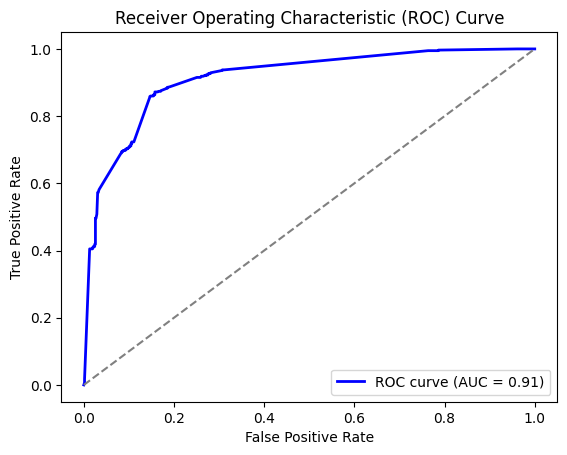

Metrics saved successfully


In [39]:
import time
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score

# Record start time for inference
start_inference_time = time.time()

# Generate predictions on test data
y_pred_proba = model.predict(X_test_preprocessed)
y_pred_binary = (y_pred_proba > 0.5).astype(int)

# Record end time for inference
end_inference_time = time.time()

# Calculate inference time
inference_time = end_inference_time - start_inference_time
print("Inference Time:", inference_time, "seconds")

# Print validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Calculate test loss and accuracy
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_encoded)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test_encoded, y_pred_proba)
print("ROC AUC Score:", roc_auc)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)
print("Confusion Matrix:")
print(conf_matrix)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)
print("Classification Report:")
print(class_report)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

kappa=cohen_kappa_score(y_test,y_pred_binary)
mcc=matthews_corrcoef(y_test,y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)

existing_metrics_df=pd.read_csv('ResNet_4000_epoch_200_metrics.csv')
metrics={
    'Combination':['ResNet+LSTM+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('ResNet_4000_epoch_200_metrics.csv',index=False)
print("Metrics saved successfully")


# ResNet+GRU+Dense

In [5]:
import tensorflow as tf
from tensorflow.keras.layers import Input, GRU, Dense, Flatten
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder

import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array

# Preprocess the loaded images
X_train_preprocessed = np.array([img_to_array(image) for image in X_train])
X_val_preprocessed = np.array([img_to_array(image) for image in X_val])
X_test_preprocessed = np.array([img_to_array(image) for image in X_test])

# Preprocess the image data
X_train_preprocessed = tf.keras.applications.resnet50.preprocess_input(X_train_preprocessed)
X_val_preprocessed = tf.keras.applications.resnet50.preprocess_input(X_val_preprocessed)
X_test_preprocessed = tf.keras.applications.resnet50.preprocess_input(X_test_preprocessed)

# Encode the labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

# Load ResNet-50 model with pre-trained ImageNet weights
resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
for layer in resnet_base.layers:
    layer.trainable = False

# Extract features using ResNet
resnet_output = resnet_base.output
flattened_output = Flatten()(resnet_output)

# Reshape features for GRU
reshaped_output = tf.keras.layers.Reshape((1, flattened_output.shape[1]))(flattened_output)

# GRU layer
gru_output = GRU(128)(reshaped_output)

# Dense layers for classification
dense_output = Dense(64, activation='relu')(gru_output)
predictions = Dense(1, activation='sigmoid')(dense_output)

# Create the model
model = Model(inputs=resnet_base.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 62,181,121 (237.20 MB)

 Trainable params: 38,593,409 (147.22 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [41]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train_preprocessed, y_train_encoded, batch_size=32, epochs=50, 
                    validation_data=(X_val_preprocessed, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 65s 897ms/step - accuracy: 0.6864 - loss: 0.5815 - val_accuracy: 0.7446 - val_loss: 0.5424
Epoch 2/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 62s 885ms/step - accuracy: 0.7895 - loss: 0.4793 - val_accuracy: 0.7804 - val_loss: 0.4627
Epoch 3/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 62s 884ms/step - accuracy: 0.7916 - loss: 0.4708 - val_accuracy: 0.7893 - val_loss: 0.4639
Epoch 4/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 62s 885ms/step - accuracy: 0.7991 - loss: 0.4281 - val_accuracy: 0.8571 - val_loss: 0.4028
Epoch 5/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 62s 885ms/step - accuracy: 0.8288 - loss: 0.3925 - val_accuracy: 0.8214 - val_loss: 0.3935
Epoch 6/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 62s 884ms/step - accuracy: 0.8543 - loss: 0.3581 - val_accuracy: 0.7875 - val_loss: 0.4322
Epoch 7/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 62s 884ms/step - accuracy: 0.8039 - loss: 0.3927 - val_accuracy: 0.7500 - val_loss: 0.4425
Epoch 8/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 62s 889ms/step - accuracy: 0.8416 - loss: 0.3789 - val_accu

38/38 ━━━━━━━━━━━━━━━━━━━━ 22s 559ms/step
Inference Time: 22.15714955329895 seconds
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 532ms/step - accuracy: 0.8243 - loss: 0.3904
Validation Loss: 0.3934621214866638
Validation Accuracy: 0.8214285969734192
38/38 ━━━━━━━━━━━━━━━━━━━━ 21s 542ms/step - accuracy: 0.8447 - loss: 0.3959
Test Loss: 0.3915634751319885
Test Accuracy: 0.8416666388511658
ROC AUC Score: 0.9111152215756739
Confusion Matrix:
[[554  68]
 [122 456]]
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.89      0.85       622
           1       0.87      0.79      0.83       578

    accuracy                           0.84      1200
   macro avg       0.84      0.84      0.84      1200
weighted avg       0.84      0.84      0.84      1200



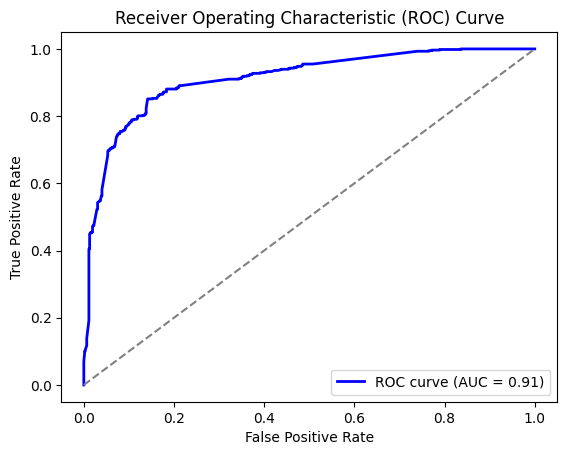

Metrics saved successfully


In [42]:
import time
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score

# Record start time for inference
start_inference_time = time.time()

# Generate predictions on test data
y_pred_proba = model.predict(X_test_preprocessed)
y_pred_binary = (y_pred_proba > 0.5).astype(int)

# Record end time for inference
end_inference_time = time.time()

# Calculate inference time
inference_time = end_inference_time - start_inference_time
print("Inference Time:", inference_time, "seconds")

# Print validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Calculate test loss and accuracy
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_encoded)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test_encoded, y_pred_proba)
print("ROC AUC Score:", roc_auc)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)
print("Confusion Matrix:")
print(conf_matrix)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)
print("Classification Report:")
print(class_report)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

kappa=cohen_kappa_score(y_test,y_pred_binary)
mcc=matthews_corrcoef(y_test,y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)

existing_metrics_df=pd.read_csv('ResNet_4000_epoch_50_metrics.csv')
metrics={
    'Combination':['ResNet+GRU+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('ResNet_4000_epoch_50_metrics.csv',index=False)
print("Metrics saved successfully")


In [6]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train_preprocessed, y_train_encoded, batch_size=32, epochs=100, 
                    validation_data=(X_val_preprocessed, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 63s 871ms/step - accuracy: 0.6589 - loss: 0.6098 - val_accuracy: 0.7143 - val_loss: 0.5259
Epoch 2/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 62s 888ms/step - accuracy: 0.7654 - loss: 0.5011 - val_accuracy: 0.7696 - val_loss: 0.4856
Epoch 3/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 62s 886ms/step - accuracy: 0.7771 - loss: 0.4691 - val_accuracy: 0.7893 - val_loss: 0.4840
Epoch 4/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 62s 884ms/step - accuracy: 0.7775 - loss: 0.4538 - val_accuracy: 0.7625 - val_loss: 0.5224
Epoch 5/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 62s 885ms/step - accuracy: 0.7742 - loss: 0.4541 - val_accuracy: 0.7821 - val_loss: 0.4659
Epoch 6/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 62s 884ms/step - accuracy: 0.7883 - loss: 0.4389 - val_accuracy: 0.7482 - val_loss: 0.5280
Epoch 7/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 62s 885ms/step - accuracy: 0.7970 - loss: 0.4684 - val_accuracy: 0.7821 - val_loss: 0.4456
Epoch 8/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 62s 884ms/step - accuracy: 0.8240 - loss: 0.3923 - 

38/38 ━━━━━━━━━━━━━━━━━━━━ 22s 557ms/step
Inference Time: 22.069745302200317 seconds
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 531ms/step - accuracy: 0.7644 - loss: 0.4432
Validation Loss: 0.43635812401771545
Validation Accuracy: 0.7732142806053162
38/38 ━━━━━━━━━━━━━━━━━━━━ 21s 539ms/step - accuracy: 0.7854 - loss: 0.4686
Test Loss: 0.4684368968009949
Test Accuracy: 0.7866666913032532
ROC AUC Score: 0.8642174479021797
Confusion Matrix:
[[534  88]
 [168 410]]
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.86      0.81       622
           1       0.82      0.71      0.76       578

    accuracy                           0.79      1200
   macro avg       0.79      0.78      0.78      1200
weighted avg       0.79      0.79      0.79      1200



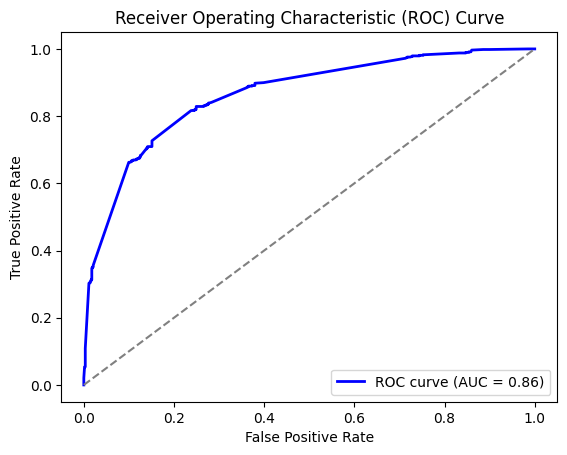

Metrics saved successfully


In [7]:
import time
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score,cohen_kappa_score,matthews_corrcoef,balanced_accuracy_score
import pandas as pd
# Record start time for inference
start_inference_time = time.time()

# Generate predictions on test data
y_pred_proba = model.predict(X_test_preprocessed)
y_pred_binary = (y_pred_proba > 0.5).astype(int)

# Record end time for inference
end_inference_time = time.time()

# Calculate inference time
inference_time = end_inference_time - start_inference_time
print("Inference Time:", inference_time, "seconds")

# Print validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Calculate test loss and accuracy
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_encoded)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test_encoded, y_pred_proba)
print("ROC AUC Score:", roc_auc)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)
print("Confusion Matrix:")
print(conf_matrix)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)
print("Classification Report:")
print(class_report)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

kappa=cohen_kappa_score(y_test,y_pred_binary)
mcc=matthews_corrcoef(y_test,y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)

existing_metrics_df=pd.read_csv('ResNet_4000_epoch_100_metrics.csv')
metrics={
    'Combination':['ResNet+GRU+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('ResNet_4000_epoch_100_metrics.csv',index=False)
print("Metrics saved successfully")

In [8]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train_preprocessed, y_train_encoded, batch_size=32, epochs=150, 
                    validation_data=(X_val_preprocessed, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/150
70/70 ━━━━━━━━━━━━━━━━━━━━ 62s 885ms/step - accuracy: 0.8151 - loss: 0.4077 - val_accuracy: 0.7125 - val_loss: 0.5645
Epoch 2/150
70/70 ━━━━━━━━━━━━━━━━━━━━ 62s 881ms/step - accuracy: 0.7564 - loss: 0.4667 - val_accuracy: 0.6982 - val_loss: 0.5343
Epoch 3/150
70/70 ━━━━━━━━━━━━━━━━━━━━ 62s 886ms/step - accuracy: 0.7609 - loss: 0.4718 - val_accuracy: 0.7607 - val_loss: 0.4782
Epoch 4/150
70/70 ━━━━━━━━━━━━━━━━━━━━ 62s 884ms/step - accuracy: 0.8195 - loss: 0.4147 - val_accuracy: 0.7036 - val_loss: 0.5877
Epoch 5/150
70/70 ━━━━━━━━━━━━━━━━━━━━ 62s 883ms/step - accuracy: 0.8059 - loss: 0.4464 - val_accuracy: 0.7107 - val_loss: 0.5225
Epoch 6/150
70/70 ━━━━━━━━━━━━━━━━━━━━ 62s 883ms/step - accuracy: 0.7815 - loss: 0.4581 - val_accuracy: 0.7482 - val_loss: 0.5701
Epoch 7/150
70/70 ━━━━━━━━━━━━━━━━━━━━ 62s 885ms/step - accuracy: 0.7756 - loss: 0.4633 - val_accuracy: 0.8161 - val_loss: 0.4106
Epoch 8/150
70/70 ━━━━━━━━━━━━━━━━━━━━ 62s 883ms/step - accuracy: 0.8474 - loss: 0.3656 - 

38/38 ━━━━━━━━━━━━━━━━━━━━ 21s 539ms/step
Inference Time: 20.836829900741577 seconds
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 531ms/step - accuracy: 0.8221 - loss: 0.4079
Validation Loss: 0.41059064865112305
Validation Accuracy: 0.8160714507102966
38/38 ━━━━━━━━━━━━━━━━━━━━ 21s 541ms/step - accuracy: 0.8146 - loss: 0.4391
Test Loss: 0.4424605667591095
Test Accuracy: 0.8141666650772095
ROC AUC Score: 0.8815323935513302
Confusion Matrix:
[[512 110]
 [113 465]]
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.82      0.82       622
           1       0.81      0.80      0.81       578

    accuracy                           0.81      1200
   macro avg       0.81      0.81      0.81      1200
weighted avg       0.81      0.81      0.81      1200



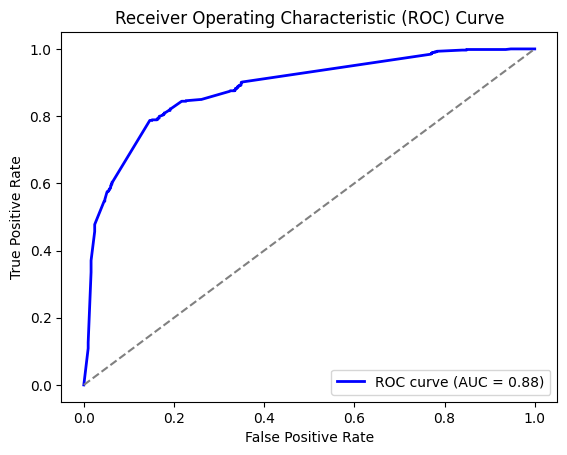

Metrics saved successfully


In [9]:
import time
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score

# Record start time for inference
start_inference_time = time.time()

# Generate predictions on test data
y_pred_proba = model.predict(X_test_preprocessed)
y_pred_binary = (y_pred_proba > 0.5).astype(int)

# Record end time for inference
end_inference_time = time.time()

# Calculate inference time
inference_time = end_inference_time - start_inference_time
print("Inference Time:", inference_time, "seconds")

# Print validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Calculate test loss and accuracy
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_encoded)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test_encoded, y_pred_proba)
print("ROC AUC Score:", roc_auc)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)
print("Confusion Matrix:")
print(conf_matrix)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)
print("Classification Report:")
print(class_report)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

kappa=cohen_kappa_score(y_test,y_pred_binary)
mcc=matthews_corrcoef(y_test,y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)

existing_metrics_df=pd.read_csv('ResNet_4000_epoch_150_metrics.csv')
metrics={
    'Combination':['ResNet+GRU+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('ResNet_4000_epoch_150_metrics.csv',index=False)
print("Metrics saved successfully")

In [10]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train_preprocessed, y_train_encoded, batch_size=32, epochs=200, 
                    validation_data=(X_val_preprocessed, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 62s 886ms/step - accuracy: 0.8471 - loss: 0.3648 - val_accuracy: 0.8464 - val_loss: 0.4062
Epoch 2/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 62s 883ms/step - accuracy: 0.8687 - loss: 0.3339 - val_accuracy: 0.8161 - val_loss: 0.4195
Epoch 3/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 62s 884ms/step - accuracy: 0.8582 - loss: 0.3518 - val_accuracy: 0.7982 - val_loss: 0.3869
Epoch 4/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 62s 882ms/step - accuracy: 0.8096 - loss: 0.3716 - val_accuracy: 0.8125 - val_loss: 0.4548
Epoch 5/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 62s 883ms/step - accuracy: 0.8221 - loss: 0.4121 - val_accuracy: 0.7071 - val_loss: 0.4715
Epoch 6/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 62s 883ms/step - accuracy: 0.7902 - loss: 0.4425 - val_accuracy: 0.8054 - val_loss: 0.4736
Epoch 7/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 62s 883ms/step - accuracy: 0.8119 - loss: 0.4129 - val_accuracy: 0.8089 - val_loss: 0.3972
Epoch 8/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 62s 883ms/step - accuracy: 0.8406 - loss: 0.3930 - 

38/38 ━━━━━━━━━━━━━━━━━━━━ 21s 540ms/step
Inference Time: 20.849781274795532 seconds
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 531ms/step - accuracy: 0.8227 - loss: 0.3773
Validation Loss: 0.38688167929649353
Validation Accuracy: 0.7982142567634583
38/38 ━━━━━━━━━━━━━━━━━━━━ 21s 540ms/step - accuracy: 0.7939 - loss: 0.4393
Test Loss: 0.4257560074329376
Test Accuracy: 0.8016666769981384
ROC AUC Score: 0.8883373758052493
Confusion Matrix:
[[522 100]
 [138 440]]
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.84      0.81       622
           1       0.81      0.76      0.79       578

    accuracy                           0.80      1200
   macro avg       0.80      0.80      0.80      1200
weighted avg       0.80      0.80      0.80      1200



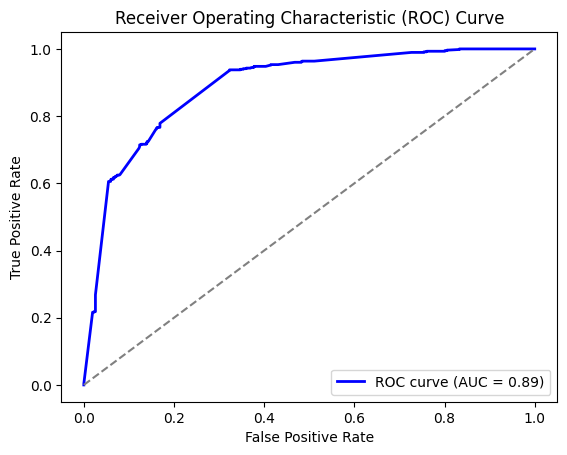

Metrics saved successfully


In [11]:
import time
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score

# Record start time for inference
start_inference_time = time.time()

# Generate predictions on test data
y_pred_proba = model.predict(X_test_preprocessed)
y_pred_binary = (y_pred_proba > 0.5).astype(int)

# Record end time for inference
end_inference_time = time.time()

# Calculate inference time
inference_time = end_inference_time - start_inference_time
print("Inference Time:", inference_time, "seconds")

# Print validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Calculate test loss and accuracy
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_encoded)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test_encoded, y_pred_proba)
print("ROC AUC Score:", roc_auc)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)
print("Confusion Matrix:")
print(conf_matrix)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)
print("Classification Report:")
print(class_report)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

kappa=cohen_kappa_score(y_test,y_pred_binary)
mcc=matthews_corrcoef(y_test,y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)

existing_metrics_df=pd.read_csv('ResNet_4000_epoch_200_metrics.csv')
metrics={
    'Combination':['ResNet+GRU+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('ResNet_4000_epoch_200_metrics.csv',index=False)
print("Metrics saved successfully")

# ResNet+Attention Mechanism+Dense

In [6]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten, Attention
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder

import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array

# Preprocess the loaded images
X_train_preprocessed = np.array([img_to_array(image) for image in X_train])
X_val_preprocessed = np.array([img_to_array(image) for image in X_val])
X_test_preprocessed = np.array([img_to_array(image) for image in X_test])

# Preprocess the image data
X_train_preprocessed = tf.keras.applications.resnet50.preprocess_input(X_train_preprocessed)
X_val_preprocessed = tf.keras.applications.resnet50.preprocess_input(X_val_preprocessed)
X_test_preprocessed = tf.keras.applications.resnet50.preprocess_input(X_test_preprocessed)

# Encode the labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

# Load ResNet-50 model with pre-trained ImageNet weights
resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
for layer in resnet_base.layers:
    layer.trainable = False

# Extract features using ResNet
resnet_output = resnet_base.output
flattened_output = Flatten()(resnet_output)

# Attention mechanism
attention_output = Attention()([flattened_output, flattened_output])

# Dense layers for classification
dense_output = Dense(64, activation='relu')(flattened_output)
predictions = Dense(1, activation='sigmoid')(dense_output)


# Create the model
model = Model(inputs=resnet_base.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 30,010,369 (114.48 MB)

 Trainable params: 6,422,657 (24.50 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [7]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train_preprocessed, y_train_encoded, batch_size=32, epochs=50, 
                    validation_data=(X_val_preprocessed, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 49s 674ms/step - accuracy: 0.5317 - loss: 5.7682 - val_accuracy: 0.4875 - val_loss: 0.6759
Epoch 2/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 49s 700ms/step - accuracy: 0.5054 - loss: 0.6761 - val_accuracy: 0.6000 - val_loss: 0.7243
Epoch 3/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 49s 705ms/step - accuracy: 0.5143 - loss: 0.6964 - val_accuracy: 0.5232 - val_loss: 0.6850
Epoch 4/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 49s 704ms/step - accuracy: 0.5619 - loss: 0.6633 - val_accuracy: 0.5732 - val_loss: 0.6780
Epoch 5/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 49s 703ms/step - accuracy: 0.5407 - loss: 0.6539 - val_accuracy: 0.6054 - val_loss: 0.6618
Epoch 6/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 49s 705ms/step - accuracy: 0.6125 - loss: 0.5987 - val_accuracy: 0.6375 - val_loss: 0.7067
Epoch 7/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 49s 705ms/step - accuracy: 0.6676 - loss: 0.5815 - val_accuracy: 0.6625 - val_loss: 0.7280
Epoch 8/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 49s 703ms/step - accuracy: 0.7362 - loss: 0.5273 - val_accu

38/38 ━━━━━━━━━━━━━━━━━━━━ 21s 547ms/step
Inference Time: 21.628547430038452 seconds
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 524ms/step - accuracy: 0.8658 - loss: 0.4237
Validation Loss: 0.4487028121948242
Validation Accuracy: 0.862500011920929
38/38 ━━━━━━━━━━━━━━━━━━━━ 20s 534ms/step - accuracy: 0.8617 - loss: 0.5080
Test Loss: 0.4841903746128082
Test Accuracy: 0.8650000095367432
ROC AUC Score: 0.8926445554578935
Confusion Matrix:
[[568  54]
 [108 470]]
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.91      0.88       622
           1       0.90      0.81      0.85       578

    accuracy                           0.86      1200
   macro avg       0.87      0.86      0.86      1200
weighted avg       0.87      0.86      0.86      1200



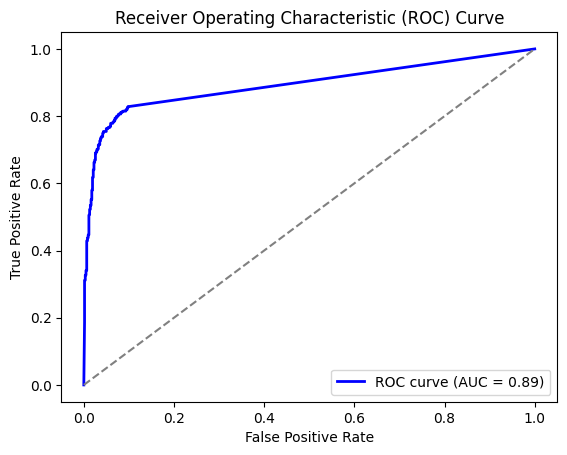

Metrics saved successfully


In [8]:
import time
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.metrics import cohen_kappa_score,matthews_corrcoef,balanced_accuracy_score
import pandas as pd
# Record start time for inference
start_inference_time = time.time()

# Generate predictions on test data
y_pred_proba = model.predict(X_test_preprocessed)
y_pred_binary = (y_pred_proba > 0.5).astype(int)

# Record end time for inference
end_inference_time = time.time()

# Calculate inference time
inference_time = end_inference_time - start_inference_time
print("Inference Time:", inference_time, "seconds")

# Print validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Calculate test loss and accuracy
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_encoded)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test_encoded, y_pred_proba)
print("ROC AUC Score:", roc_auc)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)
print("Confusion Matrix:")
print(conf_matrix)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)
print("Classification Report:")
print(class_report)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

kappa=cohen_kappa_score(y_test,y_pred_binary)
mcc=matthews_corrcoef(y_test,y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)

existing_metrics_df=pd.read_csv('ResNet_4000_epoch_50_metrics.csv')
metrics={
    'Combination':['ResNet+Attention Mechanism+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('ResNet_4000_epoch_50_metrics.csv',index=False)
print("Metrics saved successfully")

In [9]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train_preprocessed, y_train_encoded, batch_size=32, epochs=100, 
                    validation_data=(X_val_preprocessed, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 49s 707ms/step - accuracy: 0.9166 - loss: 0.2988 - val_accuracy: 0.8643 - val_loss: 0.4947
Epoch 2/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 49s 706ms/step - accuracy: 0.9370 - loss: 0.2686 - val_accuracy: 0.8589 - val_loss: 0.5658
Epoch 3/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 49s 703ms/step - accuracy: 0.9358 - loss: 0.2610 - val_accuracy: 0.8696 - val_loss: 0.5006
Epoch 4/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 49s 704ms/step - accuracy: 0.9431 - loss: 0.2416 - val_accuracy: 0.8875 - val_loss: 0.4722
Epoch 5/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 49s 704ms/step - accuracy: 0.9478 - loss: 0.2273 - val_accuracy: 0.8643 - val_loss: 0.6164
Epoch 6/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 49s 705ms/step - accuracy: 0.9459 - loss: 0.2302 - val_accuracy: 0.8875 - val_loss: 0.4982
Epoch 7/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 49s 704ms/step - accuracy: 0.9579 - loss: 0.2069 - val_accuracy: 0.8607 - val_loss: 0.6253
Epoch 8/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 49s 705ms/step - accuracy: 0.9584 - loss: 0.2017 - 

38/38 ━━━━━━━━━━━━━━━━━━━━ 20s 533ms/step
Inference Time: 20.61881422996521 seconds
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 526ms/step - accuracy: 0.8703 - loss: 0.3739
Validation Loss: 0.3895012438297272
Validation Accuracy: 0.875
38/38 ━━━━━━━━━━━━━━━━━━━━ 20s 535ms/step - accuracy: 0.8793 - loss: 0.4403
Test Loss: 0.43408945202827454
Test Accuracy: 0.8799999952316284
ROC AUC Score: 0.9021072775620556
Confusion Matrix:
[[586  36]
 [108 470]]
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.94      0.89       622
           1       0.93      0.81      0.87       578

    accuracy                           0.88      1200
   macro avg       0.89      0.88      0.88      1200
weighted avg       0.89      0.88      0.88      1200



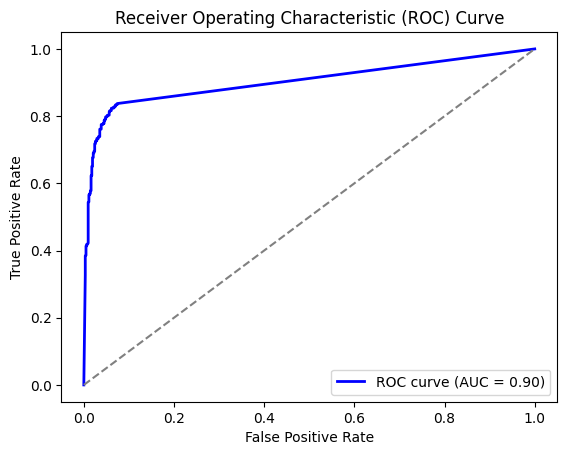

Metrics saved successfully


In [10]:
import time
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score

# Record start time for inference
start_inference_time = time.time()

# Generate predictions on test data
y_pred_proba = model.predict(X_test_preprocessed)
y_pred_binary = (y_pred_proba > 0.5).astype(int)

# Record end time for inference
end_inference_time = time.time()

# Calculate inference time
inference_time = end_inference_time - start_inference_time
print("Inference Time:", inference_time, "seconds")

# Print validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Calculate test loss and accuracy
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_encoded)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test_encoded, y_pred_proba)
print("ROC AUC Score:", roc_auc)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)
print("Confusion Matrix:")
print(conf_matrix)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)
print("Classification Report:")
print(class_report)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

kappa=cohen_kappa_score(y_test,y_pred_binary)
mcc=matthews_corrcoef(y_test,y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)

existing_metrics_df=pd.read_csv('ResNet_4000_epoch_100_metrics.csv')
metrics={
    'Combination':['ResNet+Attention Mechanism+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('ResNet_4000_epoch_100_metrics.csv',index=False)
print("Metrics saved successfully")

In [11]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train_preprocessed, y_train_encoded, batch_size=32, epochs=150, 
                    validation_data=(X_val_preprocessed, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/150
70/70 ━━━━━━━━━━━━━━━━━━━━ 49s 706ms/step - accuracy: 0.9601 - loss: 0.1736 - val_accuracy: 0.8821 - val_loss: 0.3867
Epoch 2/150
70/70 ━━━━━━━━━━━━━━━━━━━━ 49s 702ms/step - accuracy: 0.9706 - loss: 0.1545 - val_accuracy: 0.8893 - val_loss: 0.4771
Epoch 3/150
70/70 ━━━━━━━━━━━━━━━━━━━━ 49s 703ms/step - accuracy: 0.9666 - loss: 0.1581 - val_accuracy: 0.8821 - val_loss: 0.3657
Epoch 4/150
70/70 ━━━━━━━━━━━━━━━━━━━━ 49s 702ms/step - accuracy: 0.9603 - loss: 0.1667 - val_accuracy: 0.8964 - val_loss: 0.4841
Epoch 5/150
70/70 ━━━━━━━━━━━━━━━━━━━━ 49s 701ms/step - accuracy: 0.9708 - loss: 0.1438 - val_accuracy: 0.9054 - val_loss: 0.4148
Epoch 6/150
70/70 ━━━━━━━━━━━━━━━━━━━━ 49s 702ms/step - accuracy: 0.9726 - loss: 0.1406 - val_accuracy: 0.8946 - val_loss: 0.4699
Epoch 7/150
70/70 ━━━━━━━━━━━━━━━━━━━━ 49s 702ms/step - accuracy: 0.9684 - loss: 0.1458 - val_accuracy: 0.8946 - val_loss: 0.5336
Epoch 8/150
70/70 ━━━━━━━━━━━━━━━━━━━━ 49s 702ms/step - accuracy: 0.9714 - loss: 0.1365 - 

38/38 ━━━━━━━━━━━━━━━━━━━━ 20s 533ms/step
Inference Time: 20.618343353271484 seconds
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 523ms/step - accuracy: 0.8797 - loss: 0.3689
Validation Loss: 0.3656653165817261
Validation Accuracy: 0.8821428418159485
38/38 ━━━━━━━━━━━━━━━━━━━━ 20s 535ms/step - accuracy: 0.8794 - loss: 0.4270
Test Loss: 0.4175540506839752
Test Accuracy: 0.871666669845581
ROC AUC Score: 0.8953579256556037
Confusion Matrix:
[[591  31]
 [123 455]]
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.95      0.88       622
           1       0.94      0.79      0.86       578

    accuracy                           0.87      1200
   macro avg       0.88      0.87      0.87      1200
weighted avg       0.88      0.87      0.87      1200



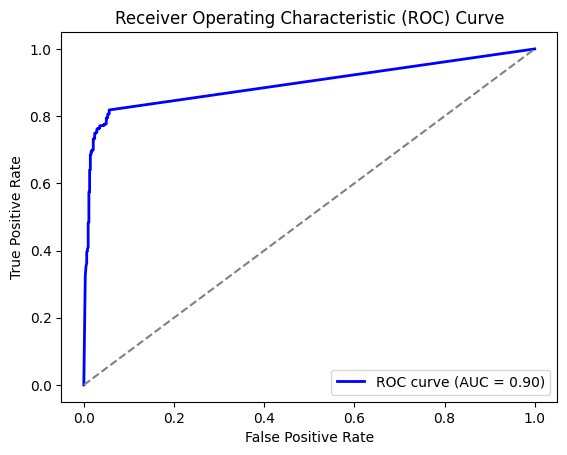

Metrics saved successfully


In [12]:
import time
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score

# Record start time for inference
start_inference_time = time.time()

# Generate predictions on test data
y_pred_proba = model.predict(X_test_preprocessed)
y_pred_binary = (y_pred_proba > 0.5).astype(int)

# Record end time for inference
end_inference_time = time.time()

# Calculate inference time
inference_time = end_inference_time - start_inference_time
print("Inference Time:", inference_time, "seconds")

# Print validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Calculate test loss and accuracy
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_encoded)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test_encoded, y_pred_proba)
print("ROC AUC Score:", roc_auc)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)
print("Confusion Matrix:")
print(conf_matrix)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)
print("Classification Report:")
print(class_report)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

kappa=cohen_kappa_score(y_test,y_pred_binary)
mcc=matthews_corrcoef(y_test,y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)

existing_metrics_df=pd.read_csv('ResNet_4000_epoch_150_metrics.csv')
metrics={
    'Combination':['ResNet+Attention Mechanism+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('ResNet_4000_epoch_150_metrics.csv',index=False)
print("Metrics saved successfully")

In [13]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train_preprocessed, y_train_encoded, batch_size=32, epochs=200, 
                    validation_data=(X_val_preprocessed, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 49s 706ms/step - accuracy: 0.9721 - loss: 0.1480 - val_accuracy: 0.8982 - val_loss: 0.4620
Epoch 2/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 49s 704ms/step - accuracy: 0.9500 - loss: 0.1867 - val_accuracy: 0.8554 - val_loss: 0.8685
Epoch 3/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 49s 703ms/step - accuracy: 0.9370 - loss: 0.2236 - val_accuracy: 0.8857 - val_loss: 0.5281
Epoch 4/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 49s 703ms/step - accuracy: 0.9685 - loss: 0.1464 - val_accuracy: 0.8911 - val_loss: 0.5058
Epoch 5/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 49s 702ms/step - accuracy: 0.9719 - loss: 0.1387 - val_accuracy: 0.9000 - val_loss: 0.3985
Epoch 6/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 49s 703ms/step - accuracy: 0.9741 - loss: 0.1260 - val_accuracy: 0.8982 - val_loss: 0.5131
Epoch 7/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 49s 702ms/step - accuracy: 0.9681 - loss: 0.1376 - val_accuracy: 0.9071 - val_loss: 0.4552
Epoch 8/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 49s 703ms/step - accuracy: 0.9748 - loss: 0.1266 - 

38/38 ━━━━━━━━━━━━━━━━━━━━ 20s 534ms/step
Inference Time: 20.637691259384155 seconds
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 523ms/step - accuracy: 0.9004 - loss: 0.3571
Validation Loss: 0.3985395133495331
Validation Accuracy: 0.8999999761581421
38/38 ━━━━━━━━━━━━━━━━━━━━ 20s 534ms/step - accuracy: 0.8777 - loss: 0.4633
Test Loss: 0.4423052668571472
Test Accuracy: 0.8816666603088379
ROC AUC Score: 0.9177658296153719
Confusion Matrix:
[[569  53]
 [ 89 489]]
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.91      0.89       622
           1       0.90      0.85      0.87       578

    accuracy                           0.88      1200
   macro avg       0.88      0.88      0.88      1200
weighted avg       0.88      0.88      0.88      1200



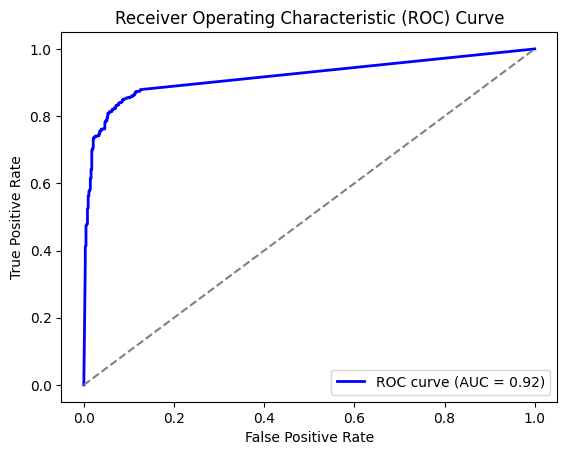

Metrics saved successfully


In [14]:
import time
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score

# Record start time for inference
start_inference_time = time.time()

# Generate predictions on test data
y_pred_proba = model.predict(X_test_preprocessed)
y_pred_binary = (y_pred_proba > 0.5).astype(int)

# Record end time for inference
end_inference_time = time.time()

# Calculate inference time
inference_time = end_inference_time - start_inference_time
print("Inference Time:", inference_time, "seconds")

# Print validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Calculate test loss and accuracy
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_encoded)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test_encoded, y_pred_proba)
print("ROC AUC Score:", roc_auc)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)
print("Confusion Matrix:")
print(conf_matrix)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)
print("Classification Report:")
print(class_report)

kappa=cohen_kappa_score(y_test,y_pred_binary)
mcc=matthews_corrcoef(y_test,y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

existing_metrics_df=pd.read_csv('ResNet_4000_epoch_200_metrics.csv')
metrics={
    'Combination':['ResNet+Attention Mechanism+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('ResNet_4000_epoch_200_metrics.csv',index=False)
print("Metrics saved successfully")

# ResNet+Capsule Network+Dense

In [6]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Layer, GlobalAveragePooling2D, Reshape, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
import cv2
import time
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, precision_score, recall_score, f1_score, cohen_kappa_score, matthews_corrcoef, balanced_accuracy_score
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd

# Define Capsule Layer
class CapsuleLayer(Layer):
    def __init__(self, num_capsule, dim_capsule, routings=3, **kwargs):
        super(CapsuleLayer, self).__init__(**kwargs)
        self.num_capsule = num_capsule
        self.dim_capsule = dim_capsule
        self.routings = routings

    def build(self, input_shape):
        input_dim_capsule = input_shape[-1]
        self.W = self.add_weight(shape=[input_dim_capsule, self.num_capsule * self.dim_capsule],
                                 initializer='glorot_uniform',
                                 name='W')

    def call(self, u_vecs):
        u_hat_vecs = tf.reduce_sum(tf.expand_dims(u_vecs, -1) * tf.expand_dims(self.W, 0), axis=-2)
        b = tf.zeros(shape=[tf.shape(u_hat_vecs)[0], self.num_capsule])
        for i in range(self.routings):
            c = tf.nn.softmax(b, axis=1)
            s_j = tf.reduce_sum(tf.multiply(c[:, :, None], u_hat_vecs), axis=1)
            v_j = self.squash(s_j)
            if i < self.routings - 1:
                b += tf.reduce_sum(tf.multiply(v_j[:, None, :], u_hat_vecs), axis=-1)
        return v_j

    def squash(self, s_j):
        s_squared_norm = tf.reduce_sum(tf.square(s_j), axis=-1, keepdims=True)
        scale = s_squared_norm / (1 + s_squared_norm) / tf.sqrt(s_squared_norm + tf.keras.backend.epsilon())
        return scale * s_j


# Start time
start_time = time.time()

# Modify the data shapes based on the model requirements
X_train_resized = np.array([cv2.resize(img, (224, 224)) for img in X_train])
X_train_resized = np.expand_dims(X_train_resized, axis=-1)  # Add channel dimension
X_train_resized = np.repeat(X_train_resized, 3, axis=-1)  # Repeat the channel dimension to match the expected input shape of ResNet50

# Example: Assuming X_test is another dataset
X_test_resized = np.array([cv2.resize(img, (224, 224)) for img in X_test])
X_test_resized = np.expand_dims(X_test_resized, axis=-1)
X_test_resized = np.repeat(X_test_resized, 3, axis=-1)

# Load pre-trained ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add Capsule Network
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Reshape((-1, 2048))(x)  # Reshape to 3D tensor for Capsule Network (2048 is the output dimension of ResNet50)
x = CapsuleLayer(num_capsule=10, dim_capsule=16, routings=3)(x)  # Example: 10 capsules with dimension 16
x = Flatten()(x)  # Flatten the output
x = Dense(128, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)  # Use a single output unit for binary classification

# Create the full model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model with Adam optimizer
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display model summary
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,936,129 (91.31 MB)

 Trainable params: 348,417 (1.33 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [18]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train_preprocessed, y_train_encoded, batch_size=32, epochs=50, 
                    validation_data=(X_val_preprocessed, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 49s 648ms/step - accuracy: 0.6662 - loss: 0.6125 - val_accuracy: 0.8321 - val_loss: 0.3963
Epoch 2/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 46s 660ms/step - accuracy: 0.8268 - loss: 0.3621 - val_accuracy: 0.8339 - val_loss: 0.3669
Epoch 3/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 48s 691ms/step - accuracy: 0.8606 - loss: 0.3170 - val_accuracy: 0.8214 - val_loss: 0.4025
Epoch 4/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 48s 688ms/step - accuracy: 0.8716 - loss: 0.2804 - val_accuracy: 0.8214 - val_loss: 0.3829
Epoch 5/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 48s 691ms/step - accuracy: 0.8872 - loss: 0.2663 - val_accuracy: 0.8196 - val_loss: 0.3809
Epoch 6/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 48s 687ms/step - accuracy: 0.8746 - loss: 0.2770 - val_accuracy: 0.8500 - val_loss: 0.3370
Epoch 7/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 48s 687ms/step - accuracy: 0.8712 - loss: 0.2604 - val_accuracy: 0.8875 - val_loss: 0.2890
Epoch 8/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 48s 686ms/step - accuracy: 0.9183 - loss: 0.1865 - val_accu

38/38 ━━━━━━━━━━━━━━━━━━━━ 21s 539ms/step
Inference Time: 20.84711503982544 seconds
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 531ms/step - accuracy: 0.8993 - loss: 0.2774
Validation Loss: 0.28896692395210266
Validation Accuracy: 0.887499988079071
38/38 ━━━━━━━━━━━━━━━━━━━━ 20s 537ms/step - accuracy: 0.8701 - loss: 0.3103
Test Loss: 0.31015828251838684
Test Accuracy: 0.871666669845581
ROC AUC Score: 0.945286162507371
Confusion Matrix:
[[552  70]
 [ 84 494]]
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.89      0.88       622
           1       0.88      0.85      0.87       578

    accuracy                           0.87      1200
   macro avg       0.87      0.87      0.87      1200
weighted avg       0.87      0.87      0.87      1200



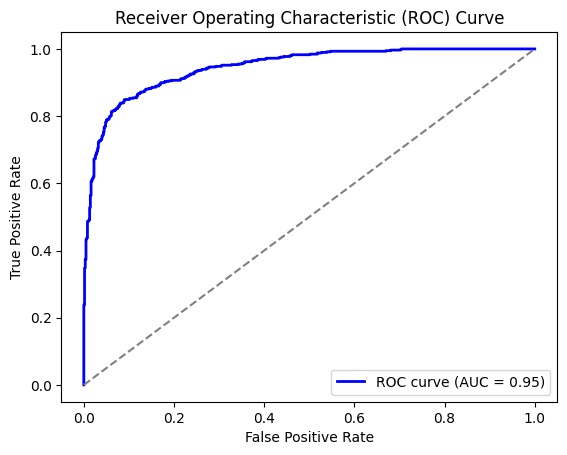

Metrics saved successfully


In [20]:
import time
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score

# Record start time for inference
start_inference_time = time.time()

# Generate predictions on test data
y_pred_proba = model.predict(X_test_preprocessed)
y_pred_binary = (y_pred_proba > 0.5).astype(int)

# Record end time for inference
end_inference_time = time.time()

# Calculate inference time
inference_time = end_inference_time - start_inference_time
print("Inference Time:", inference_time, "seconds")

# Print validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Calculate test loss and accuracy
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_encoded)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test_encoded, y_pred_proba)
print("ROC AUC Score:", roc_auc)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)
print("Confusion Matrix:")
print(conf_matrix)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)
print("Classification Report:")
print(class_report)

kappa=cohen_kappa_score(y_test,y_pred_binary)
mcc=matthews_corrcoef(y_test,y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

existing_metrics_df=pd.read_csv('ResNet_4000_epoch_50_metrics.csv')
metrics={
    'Combination':['ResNet+Capsule Network+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('ResNet_4000_epoch_50_metrics.csv',index=False)
print("Metrics saved successfully")

In [8]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train_preprocessed, y_train_encoded, batch_size=32, epochs=100, 
                    validation_data=(X_val_preprocessed, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 47s 647ms/step - accuracy: 0.6675 - loss: 0.5933 - val_accuracy: 0.8232 - val_loss: 0.4027
Epoch 2/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 46s 662ms/step - accuracy: 0.8384 - loss: 0.3678 - val_accuracy: 0.8446 - val_loss: 0.3514
Epoch 3/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 48s 687ms/step - accuracy: 0.8646 - loss: 0.3212 - val_accuracy: 0.8054 - val_loss: 0.4221
Epoch 4/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 48s 686ms/step - accuracy: 0.8614 - loss: 0.2990 - val_accuracy: 0.8625 - val_loss: 0.3131
Epoch 5/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 48s 685ms/step - accuracy: 0.8816 - loss: 0.2624 - val_accuracy: 0.8536 - val_loss: 0.3255
Epoch 6/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 48s 684ms/step - accuracy: 0.8894 - loss: 0.2523 - val_accuracy: 0.8589 - val_loss: 0.3171
Epoch 7/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 48s 685ms/step - accuracy: 0.9097 - loss: 0.2085 - val_accuracy: 0.8625 - val_loss: 0.3239
Epoch 8/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 48s 686ms/step - accuracy: 0.9125 - loss: 0.1946 - 

38/38 ━━━━━━━━━━━━━━━━━━━━ 22s 551ms/step
Inference Time: 22.35063862800598 seconds
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 526ms/step - accuracy: 0.8942 - loss: 0.2607
Validation Loss: 0.27424079179763794
Validation Accuracy: 0.887499988079071
38/38 ━━━━━━━━━━━━━━━━━━━━ 20s 536ms/step - accuracy: 0.8830 - loss: 0.3088
Test Loss: 0.2971856892108917
Test Accuracy: 0.8849999904632568
ROC AUC Score: 0.9474279308848562
Confusion Matrix:
[[567  55]
 [ 83 495]]
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.91      0.89       622
           1       0.90      0.86      0.88       578

    accuracy                           0.89      1200
   macro avg       0.89      0.88      0.88      1200
weighted avg       0.89      0.89      0.88      1200



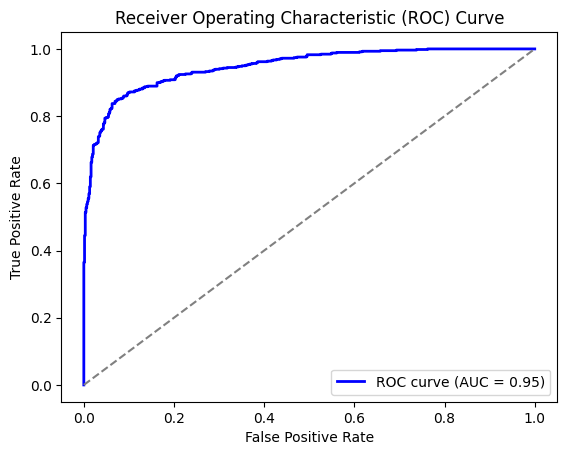

Metrics saved successfully


In [9]:
import time
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score

# Record start time for inference
start_inference_time = time.time()

# Generate predictions on test data
y_pred_proba = model.predict(X_test_preprocessed)
y_pred_binary = (y_pred_proba > 0.5).astype(int)

# Record end time for inference
end_inference_time = time.time()

# Calculate inference time
inference_time = end_inference_time - start_inference_time
print("Inference Time:", inference_time, "seconds")

# Print validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Calculate test loss and accuracy
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_encoded)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test_encoded, y_pred_proba)
print("ROC AUC Score:", roc_auc)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)
print("Confusion Matrix:")
print(conf_matrix)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)
print("Classification Report:")
print(class_report)

kappa=cohen_kappa_score(y_test,y_pred_binary)
mcc=matthews_corrcoef(y_test,y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

existing_metrics_df=pd.read_csv('ResNet_4000_epoch_100_metrics.csv')
metrics={
    'Combination':['ResNet+Capsule Network+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('ResNet_4000_epoch_100_metrics.csv',index=False)
print("Metrics saved successfully")

In [10]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train_preprocessed, y_train_encoded, batch_size=32, epochs=150, 
                    validation_data=(X_val_preprocessed, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/150
70/70 ━━━━━━━━━━━━━━━━━━━━ 48s 687ms/step - accuracy: 0.9569 - loss: 0.1111 - val_accuracy: 0.8893 - val_loss: 0.3126
Epoch 2/150
70/70 ━━━━━━━━━━━━━━━━━━━━ 48s 688ms/step - accuracy: 0.9595 - loss: 0.0945 - val_accuracy: 0.8679 - val_loss: 0.3433
Epoch 3/150
70/70 ━━━━━━━━━━━━━━━━━━━━ 48s 684ms/step - accuracy: 0.9534 - loss: 0.1091 - val_accuracy: 0.8679 - val_loss: 0.3481
Epoch 4/150
70/70 ━━━━━━━━━━━━━━━━━━━━ 48s 686ms/step - accuracy: 0.9465 - loss: 0.1243 - val_accuracy: 0.8804 - val_loss: 0.3376
Epoch 5/150
70/70 ━━━━━━━━━━━━━━━━━━━━ 48s 686ms/step - accuracy: 0.9522 - loss: 0.1154 - val_accuracy: 0.8857 - val_loss: 0.3537
Epoch 6/150
70/70 ━━━━━━━━━━━━━━━━━━━━ 48s 685ms/step - accuracy: 0.9643 - loss: 0.0788 - val_accuracy: 0.8589 - val_loss: 0.4642
Training Time: 289.5937068462372 seconds


38/38 ━━━━━━━━━━━━━━━━━━━━ 20s 536ms/step
Inference Time: 21.038700103759766 seconds
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 528ms/step - accuracy: 0.8851 - loss: 0.3003
Validation Loss: 0.31256043910980225
Validation Accuracy: 0.8892857432365417
38/38 ━━━━━━━━━━━━━━━━━━━━ 20s 538ms/step - accuracy: 0.8648 - loss: 0.3596
Test Loss: 0.3465243875980377
Test Accuracy: 0.8700000047683716
ROC AUC Score: 0.9501037505980263
Confusion Matrix:
[[538  84]
 [ 72 506]]
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.86      0.87       622
           1       0.86      0.88      0.87       578

    accuracy                           0.87      1200
   macro avg       0.87      0.87      0.87      1200
weighted avg       0.87      0.87      0.87      1200



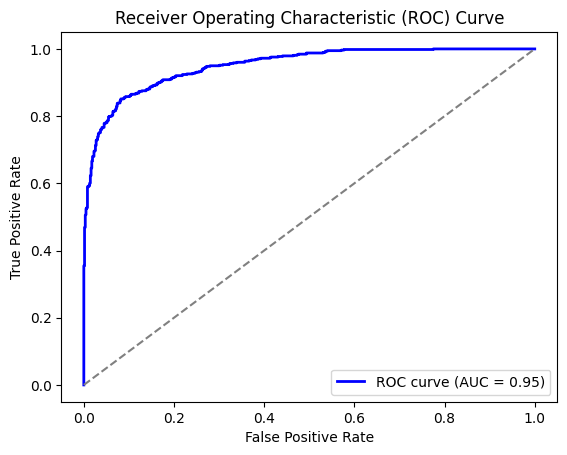

Metrics saved successfully


In [11]:
import time
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score

# Record start time for inference
start_inference_time = time.time()

# Generate predictions on test data
y_pred_proba = model.predict(X_test_preprocessed)
y_pred_binary = (y_pred_proba > 0.5).astype(int)

# Record end time for inference
end_inference_time = time.time()

# Calculate inference time
inference_time = end_inference_time - start_inference_time
print("Inference Time:", inference_time, "seconds")

# Print validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Calculate test loss and accuracy
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_encoded)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test_encoded, y_pred_proba)
print("ROC AUC Score:", roc_auc)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)
print("Confusion Matrix:")
print(conf_matrix)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)
print("Classification Report:")
print(class_report)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

kappa=cohen_kappa_score(y_test,y_pred_binary)
mcc=matthews_corrcoef(y_test,y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)

existing_metrics_df=pd.read_csv('ResNet_4000_epoch_150_metrics.csv')
metrics={
    'Combination':['ResNet+Capsule Network+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('ResNet_4000_epoch_150_metrics.csv',index=False)
print("Metrics saved successfully")

In [7]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train_preprocessed, y_train_encoded, batch_size=32, epochs=200, 
                    validation_data=(X_val_preprocessed, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 50s 681ms/step - accuracy: 0.6695 - loss: 0.6060 - val_accuracy: 0.7946 - val_loss: 0.4336
Epoch 2/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 48s 685ms/step - accuracy: 0.8179 - loss: 0.3961 - val_accuracy: 0.8464 - val_loss: 0.3543
Epoch 3/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 48s 684ms/step - accuracy: 0.8265 - loss: 0.3652 - val_accuracy: 0.8250 - val_loss: 0.3622
Epoch 4/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 48s 687ms/step - accuracy: 0.8594 - loss: 0.3144 - val_accuracy: 0.8643 - val_loss: 0.3187
Epoch 5/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 48s 686ms/step - accuracy: 0.8692 - loss: 0.2784 - val_accuracy: 0.8696 - val_loss: 0.3153
Epoch 6/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 48s 684ms/step - accuracy: 0.8982 - loss: 0.2525 - val_accuracy: 0.8482 - val_loss: 0.3397
Epoch 7/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 48s 685ms/step - accuracy: 0.8822 - loss: 0.2661 - val_accuracy: 0.8679 - val_loss: 0.3119
Epoch 8/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 48s 687ms/step - accuracy: 0.9143 - loss: 0.2082 - 

38/38 ━━━━━━━━━━━━━━━━━━━━ 22s 554ms/step
Inference Time: 22.991647481918335 seconds
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 528ms/step - accuracy: 0.8666 - loss: 0.3005
Validation Loss: 0.3055567145347595
Validation Accuracy: 0.8660714030265808
38/38 ━━━━━━━━━━━━━━━━━━━━ 21s 539ms/step - accuracy: 0.8798 - loss: 0.3000
Test Loss: 0.2980201244354248
Test Accuracy: 0.8808333277702332
ROC AUC Score: 0.9458814072252695
Confusion Matrix:
[[562  60]
 [ 83 495]]
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.90      0.89       622
           1       0.89      0.86      0.87       578

    accuracy                           0.88      1200
   macro avg       0.88      0.88      0.88      1200
weighted avg       0.88      0.88      0.88      1200



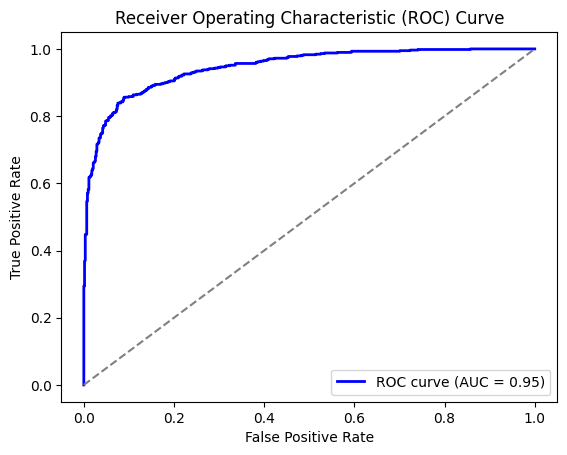

Metrics saved successfully


In [8]:
import time
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score

# Record start time for inference
start_inference_time = time.time()

# Generate predictions on test data
y_pred_proba = model.predict(X_test_preprocessed)
y_pred_binary = (y_pred_proba > 0.5).astype(int)

# Record end time for inference
end_inference_time = time.time()

# Calculate inference time
inference_time = end_inference_time - start_inference_time
print("Inference Time:", inference_time, "seconds")

# Print validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Calculate test loss and accuracy
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_encoded)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test_encoded, y_pred_proba)
print("ROC AUC Score:", roc_auc)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)
print("Confusion Matrix:")
print(conf_matrix)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)
print("Classification Report:")
print(class_report)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

kappa=cohen_kappa_score(y_test,y_pred_binary)
mcc=matthews_corrcoef(y_test,y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)

existing_metrics_df=pd.read_csv('ResNet_4000_epoch_200_metrics.csv')
metrics={
    'Combination':['ResNet+Capsule Network+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('ResNet_4000_epoch_200_metrics.csv',index=False)
print("Metrics saved successfully")
